In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
file_path = "/Users/hsuyab/Documents/Spring 2024/RA Staiger/SOAX project/Ayush/combined_filtered_data.csv"
from sklearn.metrics import mean_absolute_percentage_error as mape
#use collections to get a count frequency of each tuple
from collections import Counter

In [103]:
from tqdm import tqdm

In [104]:
#read the comparison dataset
df2 = pd.read_csv("/Users/hsuyab/Documents/Spring 2024/RA Staiger/SOAX project/Atharva/SOAX analysis/ComparisonDataset_final.csv")
#selecting the columns to filter the df2 data based upon
filterCols = ['filename','ridge', 'stretch','Original Count','Original Median Length',  'Original Median Intensity',
'Obtained Count', 'Obtained Median Length', 'Obtained Median Intensity']
#filtering the data
data = df2[filterCols].copy()

#create a list of tuples of (ridge, stretch) values
ridges = data['ridge'].values
stretches = data['stretch'].values

#zip them together as tuple
rs_params = list(zip(ridges, stretches))
#count frequency of each tuple
rs_params_count = Counter(rs_params)
#get a list of unique tuples and store it in 'params'
params = list(rs_params_count.keys())

#select a random value that has AB in it from this list(data['filename'].unique())
import random
random.seed(0)
f_ab = random.choice([i for i in list(data['filename'].unique()) if 'AB' in i])
f_bb = random.choice([i for i in list(data['filename'].unique()) if 'BB' in i])
#create copy of the data
data_original = data.copy()
#prints the randomly selected filenames for AB and BB
print(f_ab, f_bb)

AB(64) BB(109)


In [105]:
data[(data['filename'].str.contains('BB'))]['filename'].unique()

array(['BB(18)', 'BB(59)', 'BB(54)', 'BB(4)', 'BB(62)', 'BB(12)',
       'BB(109)', 'BB(26)', 'BB(20)', 'BB(17)'], dtype=object)

In [106]:
data['MAPE_Count'] = 100*(data['Original Count'] - data['Obtained Count']).abs()/data['Original Count']
data['MAPE_Length'] = 100*(data['Original Median Length'] - data['Obtained Median Length']).abs()/data['Original Median Length']
data['MAPE_Intensity'] = 100*(data['Original Median Intensity'] - data['Obtained Median Intensity']).abs()/data['Original Median Intensity']

In [107]:
data['MAPE_Count'].min(), data['MAPE_Length'].min(), data['MAPE_Intensity'].min()

(0.0, 0.020517029134188222, 0.0015896829780672576)

In [108]:
data['MAPE_Count'].max(), data['MAPE_Length'].max(), data['MAPE_Intensity'].max()

(173.52941176470588, 295.8179783255534, 76.30762090240691)

In [109]:
data['MAPE_Count'].mean(), data['MAPE_Length'].mean(), data['MAPE_Intensity'].mean()

(39.329530558179144, 35.8115166576915, 19.61581537190198)

In [12]:
def calculate_error(true_values, predicted_values, weights):
    error = sum((true_values[i] - predicted_values[i] * weights[i])**2 for i in range(len(true_values)))
    return error

def gradient_descent(true_values, predicted_values, weights, learning_rate, num_iterations):
    for _ in range(num_iterations):
        gradients = [0] * len(weights)
        for i in range(len(weights)):
            gradients[i] = -2 * (true_values[i] - predicted_values[i] * weights[i]) * predicted_values[i]
        weights = [weights[i] - learning_rate * gradients[i] for i in range(len(weights))]
    return weights

In [39]:
#calculate the weights for each of the three errors
#weights = [1/3] * 3
#true_values = data['MAPE_Count'].values

In [49]:
# (data['MAPE_Count'] + data['MAPE_Length'] + data['MAPE_Intensity'] ).mean()

94.75686258777262

In [51]:
import pandas as pd
import numpy as np
from itertools import product

def calculate_combined_mape(data, weights):
    
    mape_combined = (data['MAPE_Count'] * weights[0] +
                     data['MAPE_Length'] * weights[1] +
                     data['MAPE_Intensity'] * weights[2])/sum(weights)
    
    return mape_combined.mean()

def grid_search(data, ridge_values, stretch_values, weight_values):
    best_ridge = None
    best_stretch = None
    best_weights = None
    min_mape_combined = float('inf')

    for ridge, stretch, weights in tqdm(product(ridge_values, stretch_values, weight_values)):
        subset = data[(data['ridge'] == ridge) & (data['stretch'] == stretch)]
        if not subset.empty:
            mape_combined = calculate_combined_mape(subset, weights) #.values[0]
            if mape_combined < min_mape_combined:
                min_mape_combined = mape_combined
                best_ridge = ridge
                best_stretch = stretch
                best_weights = weights

    return best_ridge, best_stretch, best_weights, min_mape_combined

# Example usage
#data = pd.read_csv('your_data.csv')  # Load your data into a pandas DataFrame

# Define the range of ridge and stretch values to search
ridge_values = np.arange(0.01, 0.050, 0.002) #np.arange(0, 1.1, 0.1)  # Example: [0, 0.1, 0.2, ..., 1.0]
stretch_values = np.arange(0, 1.1, 0.1)  # Example: [0, 0.1, 0.2, ..., 1.0]

# Define the range of weight values to search
#weight_values = [(w1, w2, 1-w1-w2) for w1 in np.arange(0, 1.1, 0.01) for w2 in np.arange(0, 1.1-w1, 0.01)]
# Define the range of weight values to search, ensuring they are positive and sum up to 1
weight_values = [(w1, w2, 1-w1-w2) for w1 in np.arange(0.01, 1.1, 0.01) for w2 in np.arange(0.01, 1.1-w1, 0.01) if w1+w2 <= 1]


# Perform grid search
best_ridge, best_stretch, best_weights, min_mape_combined = grid_search(data, ridge_values, stretch_values, weight_values)

print("Best ridge value:", best_ridge)
print("Best stretch value:", best_stretch)
print("Best weights:", best_weights)
print("Minimum MAPE_Combined:", min_mape_combined)

0it [00:00, ?it/s]

1089000it [05:42, 3182.57it/s]

Best ridge value: 0.01
Best stretch value: 0.5
Best weights: (0.01, 0.01, 0.98)
Minimum MAPE_Combined: 3.709858631143858


In [110]:
ridge_grid = 0.01
stretch_grid = 0.5

In [111]:
data['MAPE_Combined'] = (0.01*data['MAPE_Count'] + 0.01*data['MAPE_Length'] + 0.98*data['MAPE_Intensity'])

In [112]:
# # Example usage
# # true_values = [10, 20, 30]
# # predicted_values = [8, 18, 28]
# # weights = [1, 1, 1]  # Initial weights
# learning_rate = 0.01
# num_iterations = 100

# optimized_weights = gradient_descent(true_values, predicted_values, weights, learning_rate, num_iterations)
# print("Optimized weights:", optimized_weights)

In [113]:
data_ab = data[(data['filename'].str.contains('AB'))&(data['filename']!=f_ab)]
data_bb = data[(data['filename'].str.contains('BB'))&(data['filename']!=f_bb)]

In [114]:
df_ab = data[data['filename']==f_ab]
df_bb = data[data['filename']==f_bb]

In [115]:
data_ab['MAPE_Combined'].mean(), data_bb['MAPE_Combined'].mean()

(15.78669380389844, 24.318471745436657)

In [116]:
df_ab_best = df_ab[(df_ab['ridge']==ridge_grid)&(df_ab['stretch']==stretch_grid)]
df_bb_best = df_bb[(df_bb['ridge']==ridge_grid)&(df_bb['stretch']==stretch_grid)]

In [117]:
# data_bb.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean().idxmin()

In [118]:
df_ab_best.groupby(['ridge', 'stretch'])[['MAPE_Combined']].mean()

,,MAPE_Combined
ridge,stretch,
0.01,0.5,2.835852


In [119]:
df_bb_best.groupby(['ridge', 'stretch'])[['MAPE_Combined']].mean()

,,MAPE_Combined
ridge,stretch,
0.01,0.5,2.406544


In [121]:
from glob import glob
gt_op_path = "/Users/hsuyab/Documents/Spring 2024/RA Staiger/SOAX project/Atharva/SOAX analysis/SOAX ground truth csvs 121923/"
soax_op_path = "/Users/hsuyab/Documents/Spring 2024/RA Staiger/SOAX project/Atharva/SOAX analysis/SOAX output csvs gray 121923/"

gt_op_list = glob(gt_op_path + '*.csv')
soax_op_list = glob(soax_op_path + '*/*')

for i in gt_op_list:
    if f_ab in i:
        df_ab_64_gt = pd.read_csv(i)
    if f_bb in i:
        df_bb_64_gt = pd.read_csv(i)


for i in soax_op_list:
    if f_ab in i:
        if str(ridge_grid) in i and str(stretch_grid) in i:
            df_ab_64_soax = pd.read_excel(i)
    if f_bb in i:
        if str(ridge_grid) in i and str(stretch_grid) in i:
            df_bb_64_soax = pd.read_excel(i)

df_ab_combined = pd.DataFrame()
df_bb_combined = pd.DataFrame()


count_ab = []
count_bb = []
for i in soax_op_list:
    if 'AB' in i:
        if str(ridge_grid) in i and str(stretch_grid) in i:
            df_ab_combined = pd.concat([df_ab_combined, pd.read_excel(i)], axis=0)
            count_ab.append(pd.read_excel(i).shape[0])
    if 'BB' in i:
        if str(ridge_grid) in i and str(stretch_grid) in i:
            df_bb_combined = pd.concat([df_bb_combined, pd.read_excel(i)], axis=0)
            count_bb.append(pd.read_excel(i).shape[0])



df_count = pd.DataFrame([count_ab,count_bb], index=['AB', 'BB']).T

df_ab_combined = df_ab_combined.reset_index(drop=True)


In [123]:

from scipy.stats import shapiro

def normality_test(data):
    stat, p = shapiro(data)
    alpha = 0.05
    if p > alpha:
        print("The data is normally distributed (fail to reject H0)")
        print(f"Obtained p-value: {p}")
    else:
        print("The data is not normally distributed (reject H0)")
        print(f"Obtained p-value: {p}")


#print("Normality Test for Length of Snake Body in AB")
#normality_test(df_ab_p_ab_combined['Snake Body Length']*0.267)
#print("Normality Test for Length of Snake Body in BB")
#normality_test(df_bb_p_ab_combined['Snake Body Length']*0.267)


from scipy.stats import mannwhitneyu, norm
import numpy as np
from tabulate import tabulate

def mann_whitney_u_test(data1, data2, alpha=0.05, name_data1='Data 1', name_data2='Data 2'):
    stat, p = mannwhitneyu(data1, data2)
    n1, n2 = len(data1), len(data2)
    effect_size = stat / (n1 * n2)

    z_critical = norm.ppf(1 - alpha / 2)  # Two-tailed test
    se = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    ci_low = (stat - z_critical * se) / (n1 * n2)
    ci_high = (stat + z_critical * se) / (n1 * n2)

    z_score = abs(norm.ppf(p / 2))
    power = 1 - norm.cdf(z_critical - z_score)

    median1, median2 = np.median(data1), np.median(data2)
    mean1, mean2 = np.mean(data1), np.mean(data2)
    std1, std2 = np.std(data1), np.std(data2)

    print(f"Doing Mann Whitney U Test for {name_data1} and {name_data2}")
    if p > alpha:
        print("The two datasets are not significantly different (fail to reject H0)")
    else:
        print("The two datasets are significantly different (reject H0)")

    test_results = [
        ["p-value", p],
        ["Effect size (rank biserial correlation)", effect_size],
        ["Confidence interval for the difference in medians", f"[{ci_low}, {ci_high}]"],
        ["Statistical power", power]
    ]
    print("\nTest Results:")
    print(tabulate(test_results, headers=["Metric", "Value"], tablefmt="grid"))

    descriptive_stats = [
        ["Dataset", "Median", "Mean", "Standard Deviation", "Sample Size"],
        [name_data1, median1, mean1, std1, n1],
        [name_data2, median2, mean2, std2, n2]
    ]
    print("\nDescriptive Statistics:")
    print(tabulate(descriptive_stats, headers="firstrow", tablefmt="grid"))


In [124]:
df_ab_gt = pd.DataFrame()
df_bb_gt = pd.DataFrame()
for i in gt_op_list:
    if 'AB' in i:
        #pd.read_csv(i) -> read the csv file but we will concatenate it to the df_ab_gt dataframe
        df_ab_gt = pd.concat([df_ab_gt, pd.read_csv(i)], axis=0)

    if 'BB' in i:
        #pd.read_csv(i) -> read the csv file but we will concatenate it to the df_bb_gt dataframe
        df_bb_gt = pd.concat([df_bb_gt, pd.read_csv(i)], axis=0)

,Snake Index,Average FG Intensity,Average BG Intensity,Median FG Intensity,Median BG Intensity,Euclidean Distance,Snake Body Length,Convolutedness
0,0,24651.252607,15359.060664,24654.90,15002.10,203.711186,211,1.035780
1,1,27153.418182,17068.527273,25805.90,16401.50,9.863730,11,1.115197
2,2,26275.377500,19658.911071,26719.00,20386.40,267.574862,280,1.046436
3,3,23543.679167,13854.936111,23144.95,13540.75,70.726175,72,1.018011
4,4,24145.877143,20986.085714,24295.00,20700.70,33.556906,35,1.043004
...,...,...,...,...,...,...,...,...
3162,61,27253.733333,25739.933333,26658.70,23228.05,5.192476,6,1.155518
3163,62,21461.115789,20169.442105,21359.00,20132.50,16.943099,19,1.121401
3164,63,22315.728571,20760.971429,22630.10,20747.50,6.153280,7,1.137605
3165,64,22697.357143,19288.207143,21815.40,19167.30,12.691644,14,1.103088


In [128]:
df_ab_gt

,,Area,Mean,StdDev,Mode,Median,Skew,Kurt,Length
0,1,26,45238.224,5850.806,34522.662,43349.820,0,0,25.594
1,2,55,31450.002,4297.569,30647.455,31061.580,0,0,56.168
2,3,45,37037.592,4597.009,31693.169,36704.172,0,0,45.906
3,4,39,32189.439,3534.147,33346.644,31637.920,0,0,39.815
4,5,13,29068.707,3727.045,22213.917,30160.469,0,0,13.832
...,...,...,...,...,...,...,...,...,...
29,30,54,32764.280,5254.602,28455.667,30645.645,0,0,54.385
30,31,20,19019.867,1248.098,16959.506,18965.355,0,0,20.183
31,32,64,18954.765,1263.361,16773.695,19051.471,0,0,65.265
32,33,17,18450.533,1738.625,17106.438,17946.086,0,0,16.576


In [148]:
# df_bb_gt

In [150]:
df_ab_gt_filtered = df_ab_gt[df_ab_gt['Length']>10]
df_bb_gt_filtered = df_bb_gt[df_bb_gt['Length']>10]

In [151]:
df_ab_combined_filtered = df_ab_combined[df_ab_combined['Snake Body Length']>10]
df_bb_combined_filtered = df_bb_combined[df_bb_combined['Snake Body Length']>10]

In [155]:
# df_bb_gt_filtered
# df_ab_combined_filtered

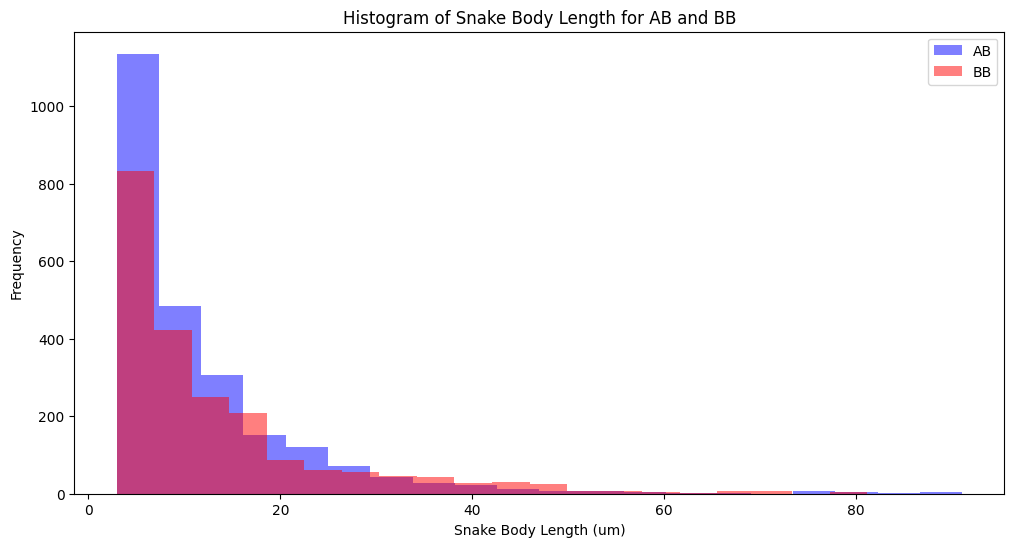

In [161]:
#do a histogram plot for df_ab_combined_filtered and df_bb_combined_filtered for length
plt.figure(figsize=(12, 6))
plt.hist(df_ab_combined_filtered['Snake Body Length']*0.267, bins=20, alpha=0.5, label='AB', color='blue')
plt.hist(df_bb_combined_filtered['Snake Body Length']*0.267, bins=20, alpha=0.5, label='BB', color='red')
plt.xlabel('Snake Body Length (um)')
plt.ylabel('Frequency')
plt.title('Histogram of Snake Body Length for AB and BB')
plt.legend()
plt.show()

In [198]:
#do mann whitney test for length
mann_whitney_u_test(df_ab_combined_filtered['Snake Body Length']*0.267, df_bb_combined_filtered['Snake Body Length']*0.267, name_data1='AB', name_data2='BB')

Doing Mann Whitney U Test for AB and BB
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-------------------------------------------+
| Metric                                            | Value                                     |
+===================================================+===========================================+
| p-value                                           | 4.4073289471631665e-05                    |
+---------------------------------------------------+-------------------------------------------+
| Effect size (rank biserial correlation)           | 0.46492373504069495                       |
+---------------------------------------------------+-------------------------------------------+
| Confidence interval for the difference in medians | [0.44809051201301203, 0.4817569580683778] |
+---------------------------------------------------+-------------------------------------------+
| Stat

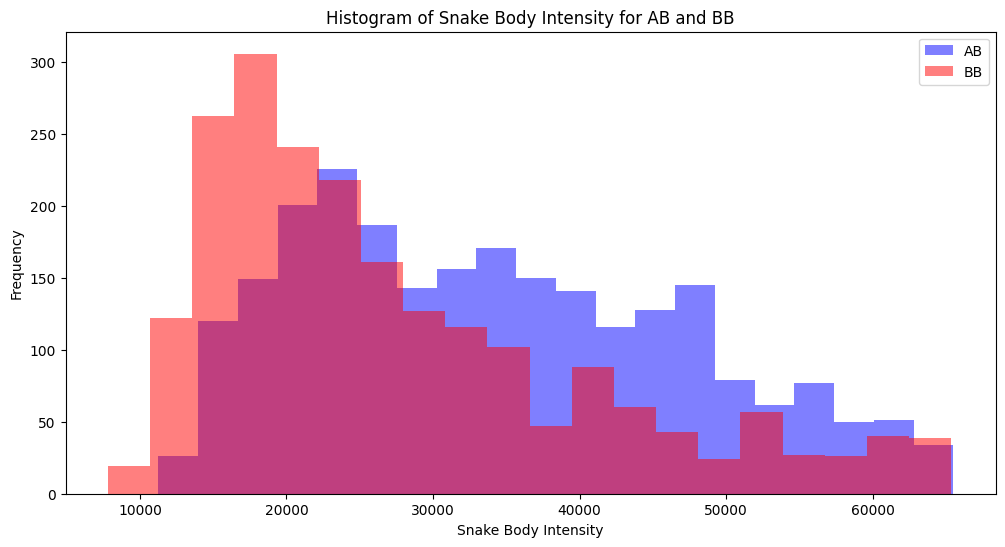

In [165]:
#do a histogram plot for df_ab_combined_filtered and df_bb_combined_filtered for intensity
plt.figure(figsize=(12, 6))
plt.hist(df_ab_combined_filtered['Average FG Intensity'], bins=20, alpha=0.5, label='AB', color='blue')
plt.hist(df_bb_combined_filtered['Average FG Intensity'], bins=20, alpha=0.5, label='BB', color='red')
plt.xlabel('Snake Body Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Snake Body Intensity for AB and BB')
plt.legend()
plt.show()

In [197]:
#do mann whitney test for intensity
mann_whitney_u_test(df_ab_combined_filtered['Average FG Intensity'], df_bb_combined_filtered['Average FG Intensity'], name_data1='AB', name_data2='BB')

Doing Mann Whitney U Test for AB and BB
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-----------------------------------------+
| Metric                                            | Value                                   |
+===================================================+=========================================+
| p-value                                           | 7.112227583951294e-80                   |
+---------------------------------------------------+-----------------------------------------+
| Effect size (rank biserial correlation)           | 0.66253730563239                        |
+---------------------------------------------------+-----------------------------------------+
| Confidence interval for the difference in medians | [0.645704082604707, 0.6793705286600729] |
+---------------------------------------------------+-----------------------------------------+
| Statistical power     

In [167]:
def process_data(data, temp_arr, count_arr):
    for i in data:
        if not temp_arr:
            temp_arr.append(i)
        elif temp_arr[-1] < i:
            temp_arr.append(i)
        elif temp_arr[-1] > i:
            count_arr.append(len(temp_arr))
            temp_arr.clear()
            temp_arr.append(i)
    return count_arr

In [188]:
# df_ab_combined_filtered

In [193]:
# process_data(df_ab_combined_filtered, [], [])
count_ab_combined_filtered = []
count_bb_combined_filtered = []
#
def count_samples(values):
    sample_counts = []
    count = 0
    for value in values:
        count += 1
        if value == 0:
            sample_counts.append(count)
            count = 0
    if count > 0:
        sample_counts.append(count)
    return sample_counts

count_ab_combined_filtered = count_samples(df_ab_combined_filtered['Snake Index'].values)
count_bb_combined_filtered = count_samples(df_bb_combined_filtered['Snake Index'].values)

In [201]:
#sum(count_bb_combined_filtered)

In [199]:
df_ab_combined_filtered

,Snake Index,Average FG Intensity,Average BG Intensity,Median FG Intensity,Median BG Intensity,Euclidean Distance,Snake Body Length,Convolutedness
0,0,24651.252607,15359.060664,24654.90,15002.10,203.711186,211,1.035780
1,1,27153.418182,17068.527273,25805.90,16401.50,9.863730,11,1.115197
2,2,26275.377500,19658.911071,26719.00,20386.40,267.574862,280,1.046436
3,3,23543.679167,13854.936111,23144.95,13540.75,70.726175,72,1.018011
4,4,24145.877143,20986.085714,24295.00,20700.70,33.556906,35,1.043004
...,...,...,...,...,...,...,...,...
3156,55,25807.085714,22544.521429,26393.15,21828.05,12.818750,14,1.092150
3157,56,19237.492000,17312.888000,18857.50,16929.60,24.019743,25,1.040810
3160,59,37963.576923,33441.676923,37094.90,31365.70,11.586438,13,1.122001
3163,62,21461.115789,20169.442105,21359.00,20132.50,16.943099,19,1.121401


In [195]:
count_ab_combined_filtered[1]+=1
count_ab_combined_filtered = count_ab_combined_filtered[1:]
count_bb_combined_filtered[1]+=1
count_bb_combined_filtered = count_bb_combined_filtered[1:]

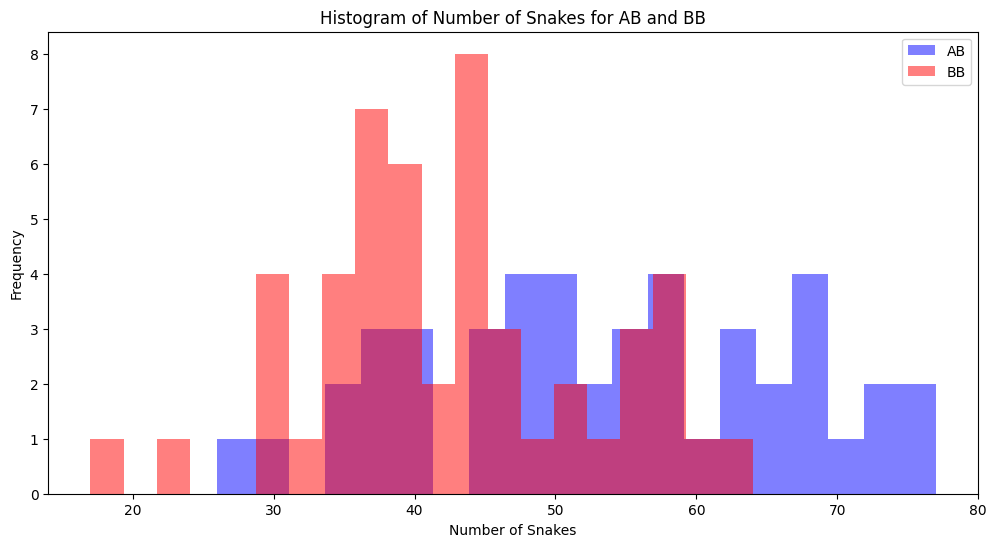

In [196]:
#plot the counts 
plt.figure(figsize=(12, 6))
plt.hist(count_ab_combined_filtered, bins=20, alpha=0.5, label='AB', color='blue')
plt.hist(count_bb_combined_filtered, bins=20, alpha=0.5, label='BB', color='red')
plt.xlabel('Number of Snakes')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Snakes for AB and BB')
plt.legend()
plt.show()

In [202]:
#mann whitney test for number of snakes
mann_whitney_u_test(count_ab_combined_filtered, count_bb_combined_filtered, name_data1='AB', name_data2='BB')

Doing Mann Whitney U Test for AB and BB
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 2.6433445911993696e-05                   |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.7506666666666667                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.6337969945897892, 0.8675363387435442] |
+---------------------------------------------------+------------------------------------------+
| Statistical p

### SEPARATE 

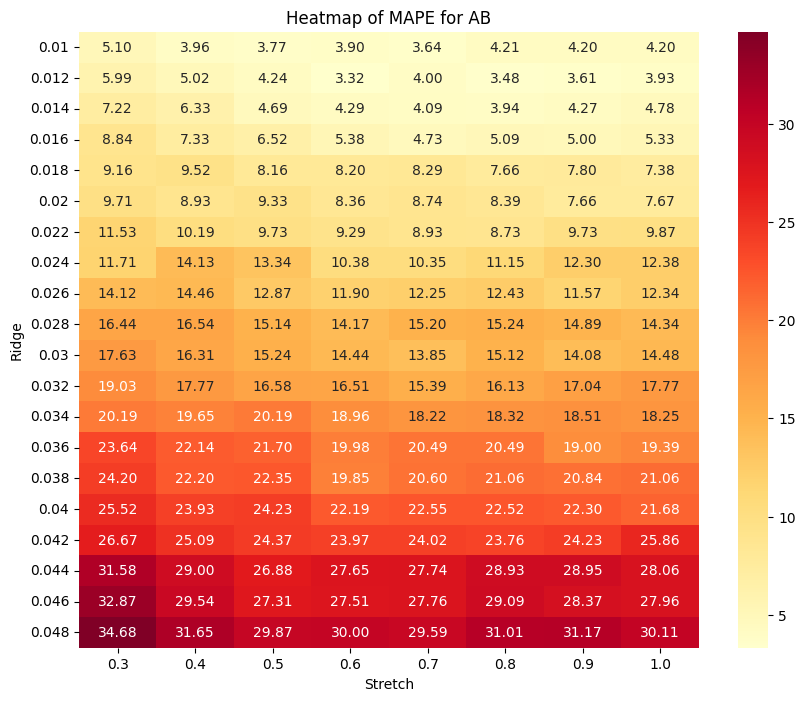

In [64]:
# data_ab.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean()
heatmap_ab = data_ab.pivot_table(index='ridge', columns='stretch', values='MAPE_Combined', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_ab, cmap='YlOrRd', annot=True, fmt='.2f')
plt.xlabel('Stretch')
plt.ylabel('Ridge')
plt.title('Heatmap of MAPE for AB')
plt.show()

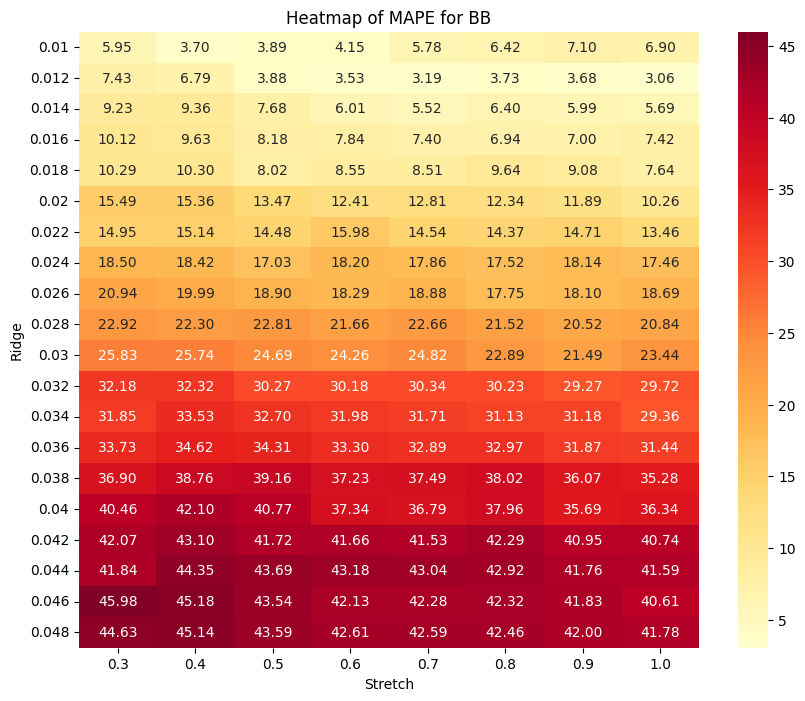

In [65]:
# data_bb.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean()
heatmap_bb = data_bb.pivot_table(index='ridge', columns='stretch', values='MAPE_Combined', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_bb, cmap='YlOrRd', annot=True, fmt='.2f')
plt.xlabel('Stretch')
plt.ylabel('Ridge')
plt.title('Heatmap of MAPE for BB')

plt.show()

In [66]:
#select the minimum value of MAPE_Combined for AB 
data_ab.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean().idxmin()


(0.012, 0.6)

In [67]:
ridge_ab = data_ab.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean().idxmin()[0]
stretch_ab = data_ab.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean().idxmin()[1]

ridge_bb = data_bb.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean().idxmin()[0]
stretch_bb = data_bb.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean().idxmin()[1]

In [68]:
print(f"Ridge AB: {ridge_ab}, Stretch AB: {stretch_ab}")
print(f"Ridge BB: {ridge_bb}, Stretch BB: {stretch_bb}")

Ridge AB: 0.012, Stretch AB: 0.6
Ridge BB: 0.012, Stretch BB: 1.0


In [69]:
df_ab_best = df_ab[(df_ab['ridge']==ridge_ab)&(df_ab['stretch']==stretch_ab)]
df_bb_best = df_bb[(df_bb['ridge']==ridge_bb)&(df_bb['stretch']==stretch_bb)]

In [70]:
# df_bb_best.T

In [71]:
#select the minimum value of MAPE_Combined for BB
data_bb.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean().idxmin()

(0.012, 1.0)

In [72]:
data_bb[(data_bb['ridge']==0.018)&(data_bb['stretch']==0.5)].groupby(['ridge', 'stretch'])[['MAPE_Combined']].mean()

,,MAPE_Combined
ridge,stretch,
0.018,0.5,8.02119


In [73]:
#select the row with the minimum value of MAPE_Combined for AB in the groupby object
#filter based on the ridge and stretch values
data_ab[(data_ab['ridge']==0.016)&(data_ab['stretch']==0.7)].groupby(['ridge', 'stretch'])[['MAPE_Combined']].mean()

,,MAPE_Combined
ridge,stretch,
0.016,0.7,4.732618


In [74]:
data_bb[['filename', 'ridge', 'stretch', 'Original Count',
       'Original Median Length', 'Original Median Intensity','MAPE_Count',
       'MAPE_Length', 'MAPE_Intensity', 'MAPE_Combined']]

,filename,ridge,stretch,Original Count,Original Median Length,Original Median Intensity,MAPE_Count,MAPE_Length,MAPE_Intensity,MAPE_Combined
0,BB(18),0.048,0.5,32,50.530,15137.1185,59.375000,119.671482,38.065742,39.094892
1,BB(18),0.026,0.5,32,50.530,15137.1185,21.875000,36.552543,27.237787,27.277307
2,BB(18),0.012,0.7,32,50.530,15137.1185,34.375000,20.839105,0.246141,0.793359
3,BB(18),0.034,0.6,32,50.530,15137.1185,31.250000,30.615476,30.802354,30.804962
4,BB(18),0.016,0.4,32,50.530,15137.1185,9.375000,6.985949,9.882144,9.848110
...,...,...,...,...,...,...,...,...,...,...
2875,BB(17),0.042,0.6,46,35.816,22502.7585,69.565217,0.513737,23.072801,23.312134
2876,BB(17),0.018,0.4,46,35.816,22502.7585,19.565217,5.070360,5.865792,5.994832
2877,BB(17),0.046,0.5,46,35.816,22502.7585,76.086957,22.850123,28.669939,29.085911
2878,BB(17),0.028,0.5,46,35.816,22502.7585,52.173913,14.473978,5.937002,6.484741


In [75]:
data_bb.groupby(['ridge', 'stretch'])['MAPE_Combined'].mean().reset_index()

,ridge,stretch,MAPE_Combined
0,0.010,0.3,5.952941
1,0.010,0.4,3.704701
2,0.010,0.5,3.894482
3,0.010,0.6,4.148580
4,0.010,0.7,5.777437
...,...,...,...
155,0.048,0.6,42.613017
156,0.048,0.7,42.594269
157,0.048,0.8,42.462578
158,0.048,0.9,42.001406


In [76]:
data[(data['filename'].str.contains('AB'))&(data['ridge']==ridge_ab)&(data['stretch']==stretch_ab)]

,filename,ridge,stretch,Original Count,Original Median Length,Original Median Intensity,Obtained Count,Obtained Median Length,Obtained Median Intensity,MAPE_Count,MAPE_Length,MAPE_Intensity,MAPE_Combined
175,AB(11),0.012,0.6,40,38.9920,39907.0840,45,33.0,39689.657143,12.500000,15.367255,0.544833,0.812609
501,AB(31),0.012,0.6,70,28.0170,25568.9600,78,20.0,25488.858079,11.428571,28.614770,0.313278,0.707446
1071,AB(101),0.012,0.6,86,18.3165,16581.6240,78,15.0,16344.788478,9.302326,18.106625,1.428301,1.673825
1123,AB(51),0.012,0.6,96,26.9530,39872.0605,94,20.5,41973.404545,2.083333,23.941676,5.270217,5.425063
1561,AB(5),0.012,0.6,84,25.0915,33645.3400,72,20.0,36482.275000,14.285714,20.291732,8.431881,8.609018
1982,AB(104),0.012,0.6,84,24.0520,33425.5470,90,19.5,34184.740000,7.142857,18.925661,2.271296,2.486555
2546,AB(64),0.012,0.6,77,40.1260,41605.0390,100,23.0,40450.605556,29.870130,42.680556,2.774744,3.444756
2715,AB(24),0.012,0.6,146,27.0270,21439.3930,67,22.0,22512.205000,54.109589,18.599919,5.003929,5.630945
3012,AB(12),0.012,0.6,34,56.6585,19008.4130,53,22.0,19020.038462,55.882353,61.170875,0.061160,1.230469


In [77]:
from glob import glob
gt_op_path = "/Users/hsuyab/Documents/Spring 2024/RA Staiger/SOAX project/Atharva/SOAX analysis/SOAX ground truth csvs 121923/"
soax_op_path = "/Users/hsuyab/Documents/Spring 2024/RA Staiger/SOAX project/Atharva/SOAX analysis/SOAX output csvs gray 121923/"

In [78]:
gt_op_list = glob(gt_op_path + '*.csv')
soax_op_list = glob(soax_op_path + '*/*')

In [79]:
for i in gt_op_list:
    if f_ab in i:
        df_ab_64_gt = pd.read_csv(i)
    if f_bb in i:
        df_bb_64_gt = pd.read_csv(i)

In [80]:
for i in soax_op_list:
    if f_ab in i:
        if str(ridge_ab) in i and str(stretch_ab) in i:
            df_ab_64_soax = pd.read_excel(i)
    if f_bb in i:
        if str(ridge_bb) in i and str(stretch_bb) in i:
            df_bb_64_soax = pd.read_excel(i)

In [81]:
df_ab_combined = pd.DataFrame()
df_bb_combined = pd.DataFrame()

In [82]:
count_ab = []
count_bb = []
for i in soax_op_list:
    if 'AB' in i:
        if str(ridge_ab) in i and str(stretch_ab) in i:
            df_ab_combined = pd.concat([df_ab_combined, pd.read_excel(i)], axis=0)
            count_ab.append(pd.read_excel(i).shape[0])
    if 'BB' in i:
        if str(ridge_bb) in i and str(stretch_bb) in i:
            df_bb_combined = pd.concat([df_bb_combined, pd.read_excel(i)], axis=0)
            count_bb.append(pd.read_excel(i).shape[0])

In [83]:
df_count = pd.DataFrame([count_ab,count_bb], index=['AB', 'BB']).T

In [84]:
df_bb_combined

,Snake Index,Average FG Intensity,Average BG Intensity,Median FG Intensity,Median BG Intensity,Euclidean Distance,Snake Body Length,Convolutedness
0,0,48234.903243,37053.376757,50201.50,34518.100,105.196182,185,1.758619
1,1,59531.663696,34715.810561,65423.00,33822.300,287.931524,303,1.052334
2,2,42289.240268,26360.410067,38572.10,23114.400,142.049636,149,1.048929
3,3,50724.442857,47066.605714,47187.50,44054.800,33.021119,35,1.059928
4,4,54627.940826,40249.757798,64458.95,44181.500,200.686774,218,1.086270
...,...,...,...,...,...,...,...,...
61,61,12436.030000,12274.170000,12367.65,12024.750,9.136266,10,1.094539
62,62,20049.812500,18936.700000,20320.85,18781.550,6.729403,8,1.188813
63,63,17160.033333,16179.033333,17101.55,15989.550,5.486524,6,1.093589
64,64,10843.386000,9669.349000,10600.55,9351.395,9.364479,10,1.067865


In [85]:
df_ab_combined = df_ab_combined.reset_index(drop=True)

In [86]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming you have two datasets: data1 and data2
# data1 = np.random.normal(0, 1, 1000)
# data2 = np.random.normal(1, 1, 1000)

# # Create the figure and subplots
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the first histogram
# ax[0].hist(data1, bins=20, alpha=0.5, label='Data 1')
# ax[0].set_title('Histogram of Data 1')
# ax[0].set_xlabel('Value')
# ax[0].set_ylabel('Frequency')
# ax[0].legend()

# # Plot the second histogram
# ax[1].hist(data2, bins=20, alpha=0.5, label='Data 2')
# ax[1].set_title('Histogram of Data 2')
# ax[1].set_xlabel('Value')
# ax[1].set_ylabel('Frequency')
# ax[1].legend()

# # Adjust the spacing
# plt.subplots_adjust(wspace=0.4)

# # Show the plot
# plt.show()

In [87]:
sns.set_palette("Paired")

In [88]:
# df_ab_64_gt

In [89]:
df_ab_64_soax.columns

Index(['Snake Index', 'Average FG Intensity', 'Average BG Intensity',
       'Median FG Intensity', 'Median BG Intensity', 'Euclidean Distance',
       'Snake Body Length', 'Convolutedness'],
      dtype='object')

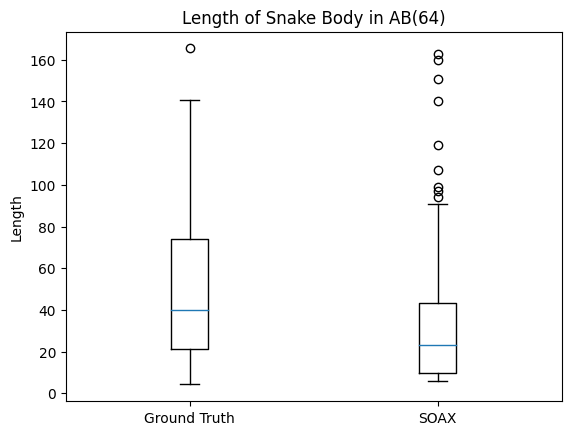

In [90]:
# Create a figure and axis objects for length comparison
fig, ax = plt.subplots()
ax.boxplot([df_ab_64_gt['Length'], df_ab_64_soax['Snake Body Length']], labels=['Ground Truth', 'SOAX'])
ax.set_title('Length of Snake Body in AB(64)')
ax.set_ylabel('Length')
plt.show()

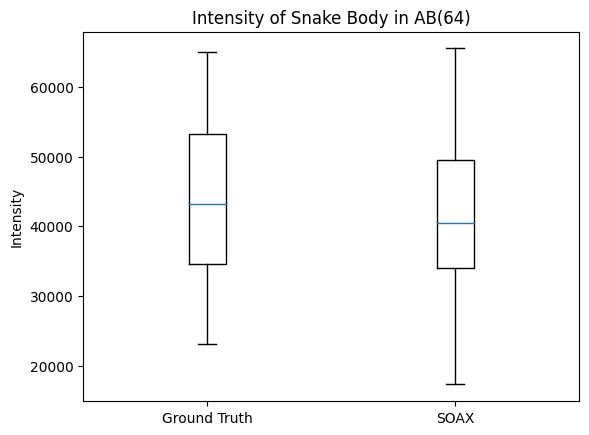

In [91]:
# Create a figure and axis objects for intensity comparison
fig, ax = plt.subplots()
ax.boxplot([df_ab_64_gt['Mean'], df_ab_64_soax['Average FG Intensity']], labels=['Ground Truth', 'SOAX'])
# Customizing colors for boxes and whiskers
ax.set_title('Intensity of Snake Body in AB(64)')
ax.set_ylabel('Intensity')
plt.show()


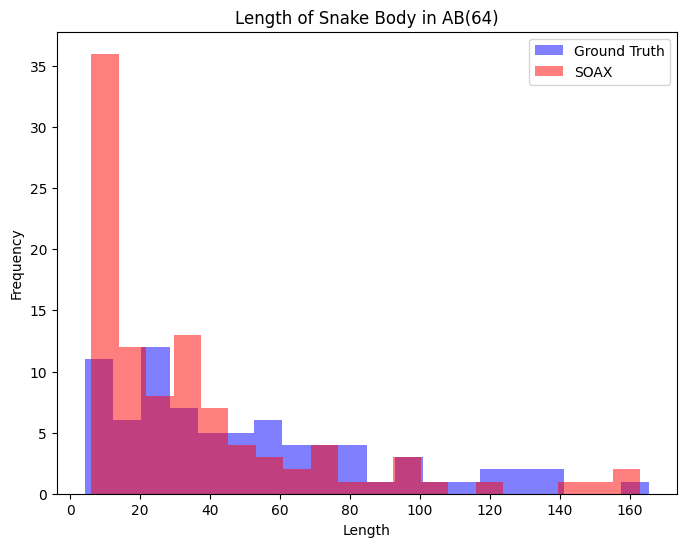

In [92]:
import matplotlib.pyplot as plt

# Histogram 1: Length of Snake Body
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_64_gt['Length'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_ab_64_soax['Snake Body Length'], bins=20, alpha=0.5, label='SOAX', color='red')
ax.set_title('Length of Snake Body in AB(64)')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


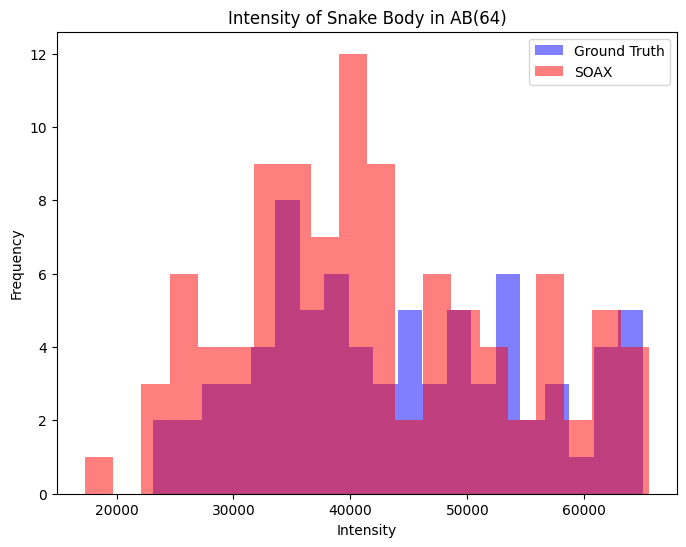

In [93]:
# Histogram 2: Intensity of Snake Body
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_64_gt['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_ab_64_soax['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX', color='red')
ax.set_title('Intensity of Snake Body in AB(64)')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

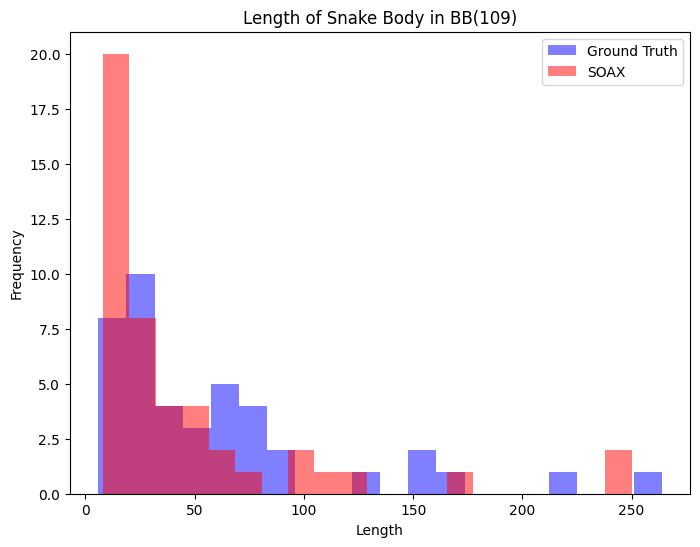

In [94]:

# Histogram 1: Length of Snake Body
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_bb_64_gt['Length'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_bb_64_soax['Snake Body Length'], bins=20, alpha=0.5, label='SOAX', color='red')
ax.set_title('Length of Snake Body in BB(109)')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


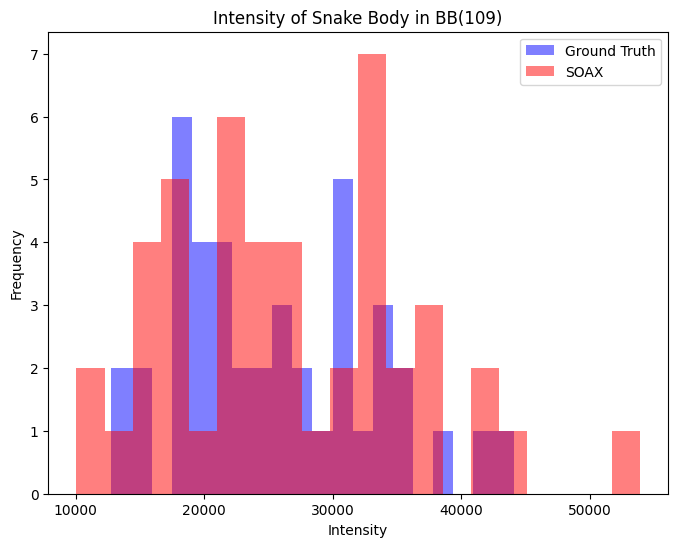

In [95]:
# Histogram 2: Intensity of Snake Body
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_bb_64_gt['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_bb_64_soax['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX', color='red')
ax.set_title('Intensity of Snake Body in BB(109)')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [96]:
df_ab_combined.columns

Index(['Snake Index', 'Average FG Intensity', 'Average BG Intensity',
       'Median FG Intensity', 'Median BG Intensity', 'Euclidean Distance',
       'Snake Body Length', 'Convolutedness'],
      dtype='object')

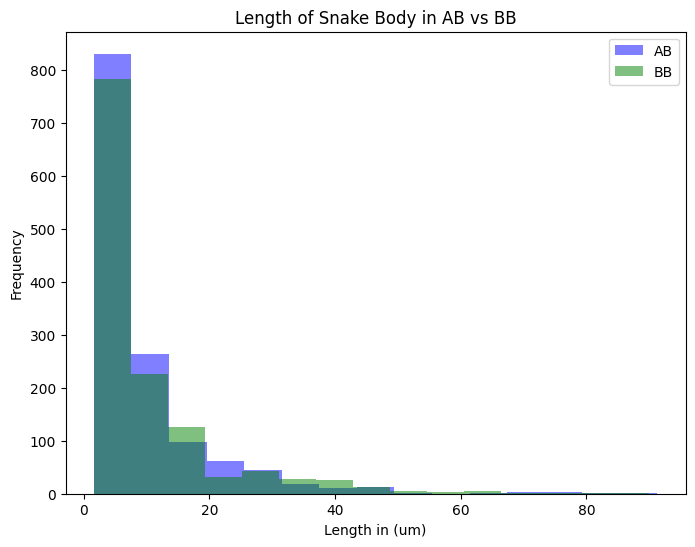

In [97]:
count_ab = []
count_bb = []
for i in soax_op_list:
    if 'AB' in i:
        if str(ridge_ab) in i and str(stretch_ab) in i:
            df_ab_combined = pd.concat([df_ab_combined, pd.read_excel(i)], axis=0)
            count_ab.append(pd.read_excel(i).shape[0])
    if 'BB' in i:
        # if str(ridge_bb) in i and str(stretch_bb) in i:
        if str(ridge_ab) in i and str(stretch_ab) in i:
            df_bb_combined = pd.concat([df_bb_combined, pd.read_excel(i)], axis=0)
            count_bb.append(pd.read_excel(i).shape[0])

# Histogram 5: Snake Length Across Distributions
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_combined['Snake Body Length']*0.267, bins=15, alpha=0.5, label='AB', color='blue')
ax.hist(df_bb_combined['Snake Body Length']*0.267, bins=15, alpha=0.5, label='BB', color='green')
ax.set_title('Length of Snake Body in AB vs BB')
ax.set_xlabel('Length in (um)')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [98]:
df_ab_combined.columns

Index(['Snake Index', 'Average FG Intensity', 'Average BG Intensity',
       'Median FG Intensity', 'Median BG Intensity', 'Euclidean Distance',
       'Snake Body Length', 'Convolutedness'],
      dtype='object')

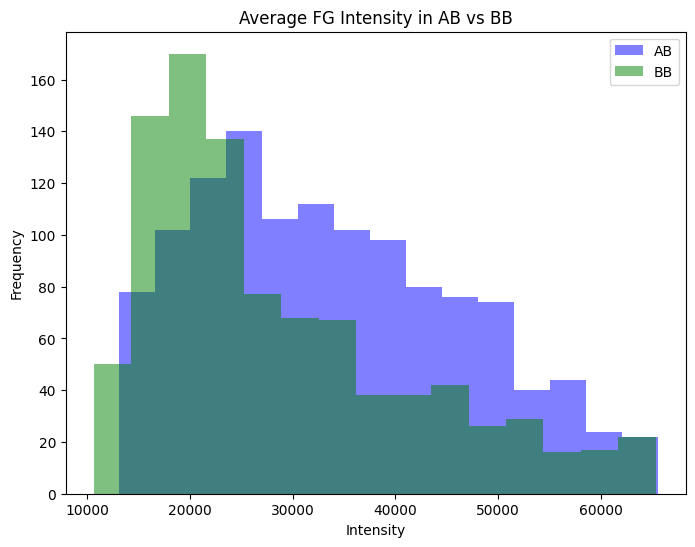

In [47]:
# Histogram 5: Snake Length Across Distributions
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_combined['Average FG Intensity'], bins=15, alpha=0.5, label='AB', color='blue')
ax.hist(df_bb_combined['Average FG Intensity'], bins=15, alpha=0.5, label='BB', color='green')
ax.set_title('Average FG Intensity in AB vs BB')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

### Data with AB Parameters

In [48]:
ridge_ab, stretch_ab

(0.016, 0.7)

In [49]:
df_ab_p_ab_combined = pd.DataFrame()
df_bb_p_ab_combined = pd.DataFrame()

count_ab_p_ab = []
count_bb_p_ab = []
for i in soax_op_list:
    if 'AB' in i:
        if str(ridge_ab) in i and str(stretch_ab) in i:
            df_ab_p_ab_combined = pd.concat([df_ab_p_ab_combined, pd.read_excel(i)], axis=0)
            count_ab_p_ab.append(pd.read_excel(i).shape[0])
    if 'BB' in i:
        if str(ridge_ab) in i and str(stretch_ab) in i:
            df_bb_p_ab_combined = pd.concat([df_bb_p_ab_combined, pd.read_excel(i)], axis=0)
            count_bb_p_ab.append(pd.read_excel(i).shape[0])

## Data with BB parameters

In [50]:
ridge_bb, stretch_bb

(0.018, 0.5)

In [51]:
#now do as above for the best parameters for BB
df_ab_p_bb_combined = pd.DataFrame()
df_bb_p_bb_combined = pd.DataFrame()

count_ab_p_bb = []
count_bb_p_bb = []

for i in soax_op_list:
    if 'AB' in i:
        if str(ridge_bb) in i and str(stretch_bb) in i:
            df_ab_p_bb_combined = pd.concat([df_ab_p_bb_combined, pd.read_excel(i)], axis=0)
            count_ab_p_bb.append(pd.read_excel(i).shape[0])
    if 'BB' in i:
        if str(ridge_bb) in i and str(stretch_bb) in i:
            df_bb_p_bb_combined = pd.concat([df_bb_p_bb_combined, pd.read_excel(i)], axis=0)
            count_bb_p_bb.append(pd.read_excel(i).shape[0])

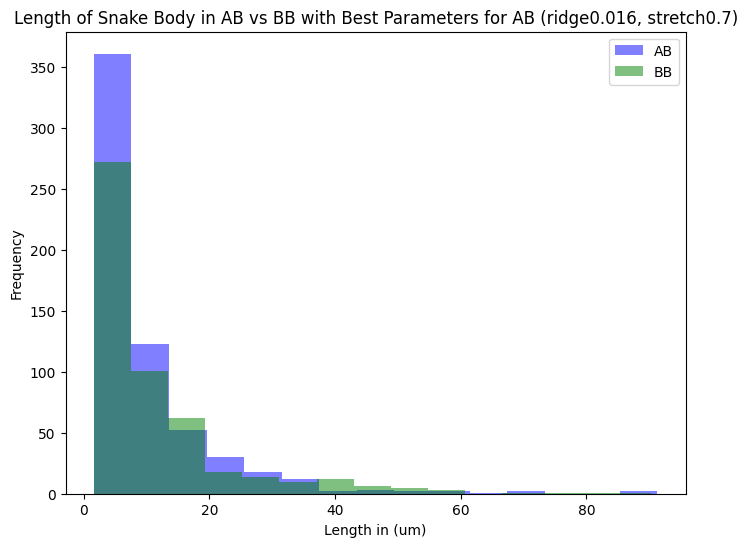

In [52]:
# Histogram 5: Snake Length Across Distributions
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_p_ab_combined['Snake Body Length']*0.267, bins=15, alpha=0.5, label='AB', color='blue')
ax.hist(df_bb_p_ab_combined['Snake Body Length']*0.267, bins=15, alpha=0.5, label='BB', color='green')
ax.set_title(f'Length of Snake Body in AB vs BB with Best Parameters for AB (ridge{ridge_ab}, stretch{stretch_ab})') 
ax.set_xlabel('Length in (um)')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

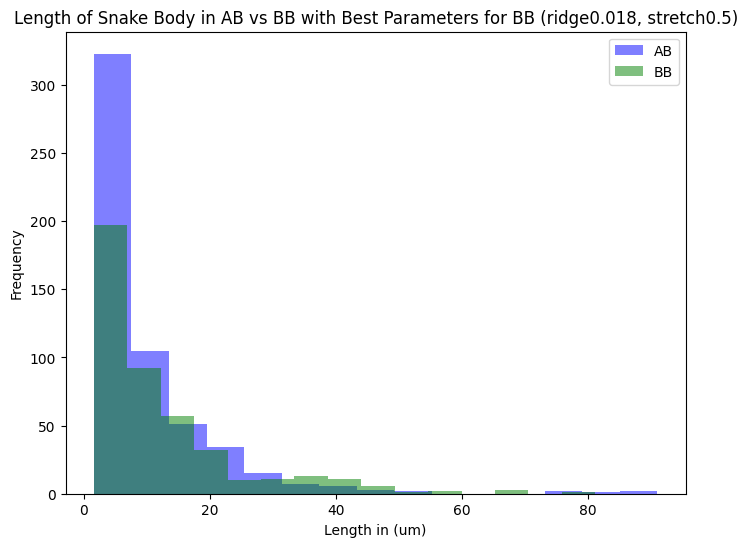

In [53]:
#now do as above for the best parameters for BB
# Histogram 5: Snake Length Across Distributions
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_p_bb_combined['Snake Body Length']*0.267, bins=15, alpha=0.5, label='AB', color='blue')
ax.hist(df_bb_p_bb_combined['Snake Body Length']*0.267, bins=15, alpha=0.5, label='BB', color='green')
ax.set_title(f'Length of Snake Body in AB vs BB with Best Parameters for BB (ridge{ridge_bb}, stretch{stretch_bb})')
ax.set_xlabel('Length in (um)')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


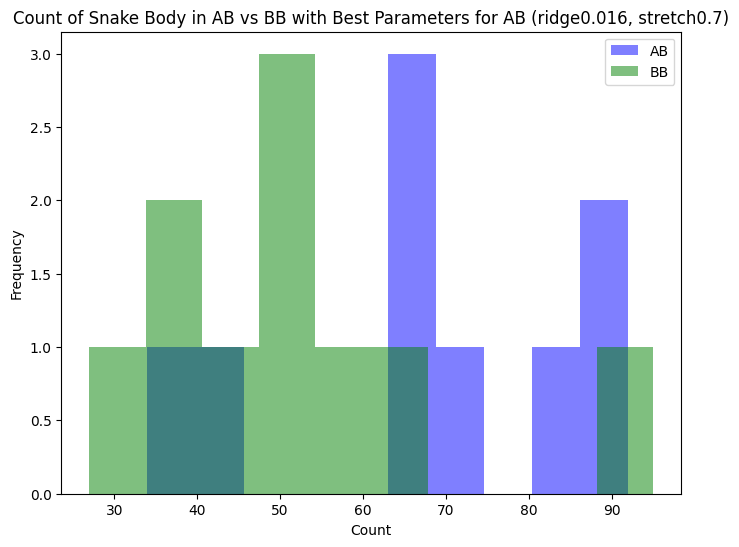

In [54]:
#do the same for count
# Histogram 5: Snake Length Across Distributions
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(count_ab_p_ab,bins=10, alpha=0.5, label='AB', color='blue')
ax.hist(count_bb_p_ab,bins=10, alpha=0.5, label='BB', color='green')
ax.set_title(f'Count of Snake Body in AB vs BB with Best Parameters for AB (ridge{ridge_ab}, stretch{stretch_ab})')
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

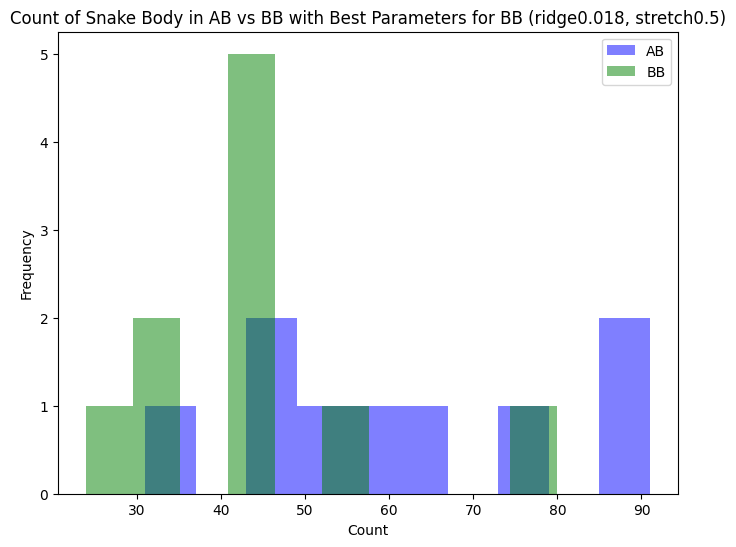

In [55]:
#now do as above for the best parameters for BB
# Histogram 5: Snake Length Across Distributions
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(count_ab_p_bb,bins=10, alpha=0.5, label='AB', color='blue')
ax.hist(count_bb_p_bb,bins=10, alpha=0.5, label='BB', color='green')
ax.set_title(f'Count of Snake Body in AB vs BB with Best Parameters for BB (ridge{ridge_bb}, stretch{stretch_bb})')
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

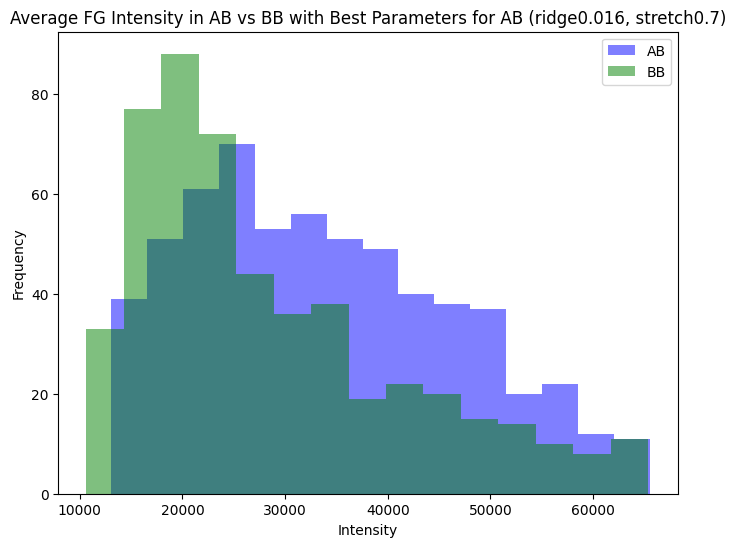

In [56]:
#do the same for intensity
# Histogram 5: Snake Length Across Distributions
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_p_ab_combined['Average FG Intensity'], bins=15, alpha=0.5, label='AB', color='blue')
ax.hist(df_bb_p_ab_combined['Average FG Intensity'], bins=15, alpha=0.5, label='BB', color='green')
ax.set_title(f'Average FG Intensity in AB vs BB with Best Parameters for AB (ridge{ridge_ab}, stretch{stretch_ab})')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

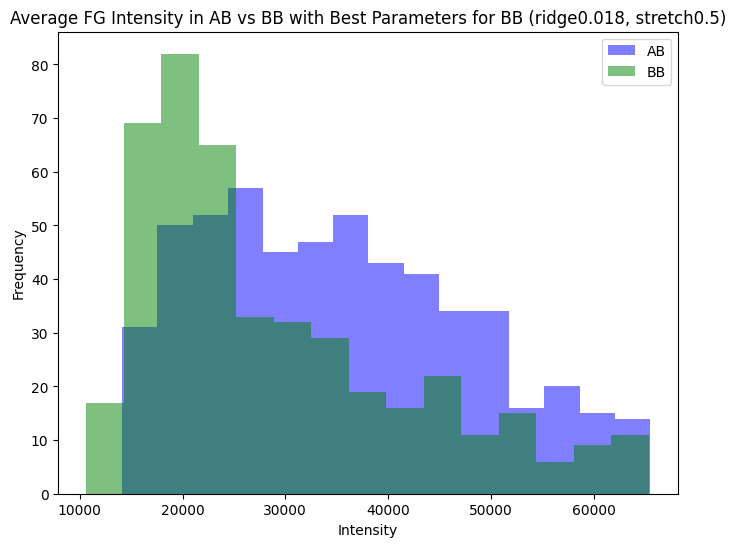

In [57]:
#now do as above for the best parameters for BB
# Histogram 5: Snake Length Across Distributions
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_p_bb_combined['Average FG Intensity'], bins=15, alpha=0.5, label='AB', color='blue')
ax.hist(df_bb_p_bb_combined['Average FG Intensity'], bins=15, alpha=0.5, label='BB', color='green')
ax.set_title(f'Average FG Intensity in AB vs BB with Best Parameters for BB (ridge{ridge_bb}, stretch{stretch_bb})')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [58]:
df_ab_p_ab_combined.head(2)

,Snake Index,Average FG Intensity,Average BG Intensity,Median FG Intensity,Median BG Intensity,Euclidean Distance,Snake Body Length,Convolutedness
0,0,24639.789623,15377.851887,24803.25,15026.2,205.215148,212,1.033062
1,1,27043.954545,17110.872727,25672.60,16445.0,9.902340,11,1.110849


In [59]:
from scipy.stats import shapiro

def normality_test(data):
    stat, p = shapiro(data)
    alpha = 0.05
    if p > alpha:
        print("The data is normally distributed (fail to reject H0)")
        print(f"Obtained p-value: {p}")
    else:
        print("The data is not normally distributed (reject H0)")
        print(f"Obtained p-value: {p}")

In [60]:
from scipy.stats import levene

def equality_of_variances_test(data1, data2):
    stat, p = levene(data1, data2)
    alpha = 0.05
    if p > alpha:
        print("The variances are equal (fail to reject H0)")
        print(f"Obtained p-value: {p}")
    else:
        print("The variances are not equal (reject H0)")
        print(f"Obtained p-value: {p}")

In [61]:
print("Normality Test for Length of Snake Body in AB")
normality_test(df_ab_p_ab_combined['Snake Body Length']*0.267)
print("Normality Test for Length of Snake Body in BB")
normality_test(df_bb_p_ab_combined['Snake Body Length']*0.267)


Normality Test for Length of Snake Body in AB
The data is not normally distributed (reject H0)
Obtained p-value: 1.620924975643082e-32
Normality Test for Length of Snake Body in BB
The data is not normally distributed (reject H0)
Obtained p-value: 1.3829202938789593e-28


In [62]:
print("Equality of Variances Test for Length of Snake Body in AB vs BB with Best Parameters for AB")
equality_of_variances_test(df_ab_p_ab_combined['Snake Body Length']*0.267, df_bb_p_ab_combined['Snake Body Length']*0.267)

Equality of Variances Test for Length of Snake Body in AB vs BB with Best Parameters for AB
The variances are not equal (reject H0)
Obtained p-value: 0.023486182767093373


In [63]:
print("Equality of Variances Test for Length of Snake Body in AB vs BB with Best Parameters for BB")
equality_of_variances_test(df_ab_p_bb_combined['Snake Body Length']*0.267, df_bb_p_bb_combined['Snake Body Length']*0.267)

Equality of Variances Test for Length of Snake Body in AB vs BB with Best Parameters for BB
The variances are not equal (reject H0)
Obtained p-value: 0.014921719522126956


In [64]:
print("Normality Test for Length of Snake Body in AB")
normality_test(df_ab_p_bb_combined['Snake Body Length']*0.267)
print("Normality Test for Length of Snake Body in BB")
normality_test(df_bb_p_bb_combined['Snake Body Length']*0.267)

print("Equality of Variances Test for Length of Snake Body in AB vs BB \n with Best Parameters for BB")
equality_of_variances_test(df_ab_p_bb_combined['Snake Body Length']*0.267, df_bb_p_bb_combined['Snake Body Length']*0.267)

Normality Test for Length of Snake Body in AB
The data is not normally distributed (reject H0)
Obtained p-value: 1.6060936084921557e-31
Normality Test for Length of Snake Body in BB
The data is not normally distributed (reject H0)
Obtained p-value: 5.257316803089723e-25
Equality of Variances Test for Length of Snake Body in AB vs BB 
 with Best Parameters for BB
The variances are not equal (reject H0)
Obtained p-value: 0.014921719522126956


### Tests for 'Average FG Intensity'

In [65]:
print("Normality Test for Average FG Intensity in AB")
normality_test(df_ab_p_ab_combined['Average FG Intensity'])

print("Normality Test for Average FG Intensity in BB")
normality_test(df_bb_p_ab_combined['Average FG Intensity'])


print("Equality of Variances Test for Average FG Intensity in AB vs BB \n with Best Parameters for AB")
equality_of_variances_test(df_ab_p_ab_combined['Average FG Intensity'], df_bb_p_ab_combined['Average FG Intensity'])


Normality Test for Average FG Intensity in AB
The data is not normally distributed (reject H0)
Obtained p-value: 2.7084096132386145e-11
Normality Test for Average FG Intensity in BB
The data is not normally distributed (reject H0)
Obtained p-value: 1.0128074813243369e-17
Equality of Variances Test for Average FG Intensity in AB vs BB 
 with Best Parameters for AB
The variances are equal (fail to reject H0)
Obtained p-value: 0.22302577837206056


In [66]:
print("Normality Test for Average FG Intensity in AB")
normality_test(df_ab_p_bb_combined['Average FG Intensity'])

print("Normality Test for Average FG Intensity in BB")
normality_test(df_bb_p_bb_combined['Average FG Intensity'])


print("Equality of Variances Test for Average FG Intensity in AB vs BB \n with Best Parameters for BB")
equality_of_variances_test(df_ab_p_bb_combined['Average FG Intensity'], df_bb_p_bb_combined['Average FG Intensity'])


Normality Test for Average FG Intensity in AB
The data is not normally distributed (reject H0)
Obtained p-value: 4.5921884460851725e-10
Normality Test for Average FG Intensity in BB
The data is not normally distributed (reject H0)
Obtained p-value: 7.106220591294499e-17
Equality of Variances Test for Average FG Intensity in AB vs BB 
 with Best Parameters for BB
The variances are equal (fail to reject H0)
Obtained p-value: 0.39596755801983363


In [67]:
# from scipy.stats import mannwhitneyu, norm

# def mann_whitney_u_test(data1, data2):
#     stat, p = mannwhitneyu(data1, data2)
#     n1, n2 = len(data1), len(data2)
#     effect_size = stat / (n1 * n2)
    
#     # Calculate the confidence interval for the difference in medians
#     z_critical = norm.ppf(0.975)  # Two-tailed test with alpha = 0.05
#     se = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
#     ci_low = (stat - z_critical * se) / (n1 * n2)
#     ci_high = (stat + z_critical * se) / (n1 * n2)
    
#     # Descriptive statistics
#     median1, median2 = np.median(data1), np.median(data2)
#     mean1, mean2 = np.mean(data1), np.mean(data2)
#     std1, std2 = np.std(data1), np.std(data2)
    
#     alpha = 0.05
#     if p > alpha:
#         print("The two datasets are not significantly different (fail to reject H0)")
#     else:
#         print("The two datasets are significantly different (reject H0)")
    
#     print(f"Obtained p-value: {p}")
#     print(f"Effect size (rank biserial correlation): {effect_size}")
#     print(f"Confidence interval for the difference in medians: [{ci_low}, {ci_high}]")
#     print("Descriptive Statistics:")
#     print(f"Dataset 1 - Median: {median1}, Mean: {mean1}, Standard Deviation: {std1}, Sample Size: {n1}")
#     print(f"Dataset 2 - Median: {median2}, Mean: {mean2}, Standard Deviation: {std2}, Sample Size: {n2}")


from scipy.stats import mannwhitneyu, norm
from scipy.stats import norm

# def mann_whitney_u_test(data1, data2, alpha=0.05, name_data1='Data 1', name_data2='Data 2'):
#     stat, p = mannwhitneyu(data1, data2)
#     n1, n2 = len(data1), len(data2)
#     effect_size = stat / (n1 * n2)

#     # Calculate the confidence interval for the difference in medians
#     z_critical = norm.ppf(1 - alpha / 2)  # Two-tailed test
#     se = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
#     ci_low = (stat - z_critical * se) / (n1 * n2)
#     ci_high = (stat + z_critical * se) / (n1 * n2)

#     # Calculate statistical power
#     z_score = abs(norm.ppf(p / 2))
#     power = 1 - norm.cdf(z_critical - z_score)

#     # Descriptive statistics
#     median1, median2 = np.median(data1), np.median(data2)
#     mean1, mean2 = np.mean(data1), np.mean(data2)
#     std1, std2 = np.std(data1), np.std(data2)
#     print(f"Doing Mann Whitney U Test for {name_data1} and {name_data2}")
#     if p > alpha:
#         print("The two datasets are not significantly different (fail to reject H0)")
#     else:
#         print("The two datasets are significantly different (reject H0)")

#     print(f"Obtained p-value: {p}")
#     print(f"Effect size (rank biserial correlation): {effect_size}")
#     print(f"Confidence interval for the difference in medians: [{ci_low}, {ci_high}]")
#     print(f"Statistical power: {power}")
#     print("Descriptive Statistics:")
#     print(f"Dataset 1 - Median: {median1}, Mean: {mean1}, Standard Deviation: {std1}, Sample Size: {n1}")
#     print(f"Dataset 2 - Median: {median2}, Mean: {mean2}, Standard Deviation: {std2}, Sample Size: {n2}")

In [68]:
from scipy.stats import mannwhitneyu, norm
import numpy as np
from tabulate import tabulate

def mann_whitney_u_test(data1, data2, alpha=0.05, name_data1='Data 1', name_data2='Data 2'):
    stat, p = mannwhitneyu(data1, data2)
    n1, n2 = len(data1), len(data2)
    effect_size = stat / (n1 * n2)

    z_critical = norm.ppf(1 - alpha / 2)  # Two-tailed test
    se = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    ci_low = (stat - z_critical * se) / (n1 * n2)
    ci_high = (stat + z_critical * se) / (n1 * n2)

    z_score = abs(norm.ppf(p / 2))
    power = 1 - norm.cdf(z_critical - z_score)

    median1, median2 = np.median(data1), np.median(data2)
    mean1, mean2 = np.mean(data1), np.mean(data2)
    std1, std2 = np.std(data1), np.std(data2)

    print(f"Doing Mann Whitney U Test for {name_data1} and {name_data2}")
    if p > alpha:
        print("The two datasets are not significantly different (fail to reject H0)")
    else:
        print("The two datasets are significantly different (reject H0)")

    test_results = [
        ["p-value", p],
        ["Effect size (rank biserial correlation)", effect_size],
        ["Confidence interval for the difference in medians", f"[{ci_low}, {ci_high}]"],
        ["Statistical power", power]
    ]
    print("\nTest Results:")
    print(tabulate(test_results, headers=["Metric", "Value"], tablefmt="grid"))

    descriptive_stats = [
        ["Dataset", "Median", "Mean", "Standard Deviation", "Sample Size"],
        [name_data1, median1, mean1, std1, n1],
        [name_data2, median2, mean2, std2, n2]
    ]
    print("\nDescriptive Statistics:")
    print(tabulate(descriptive_stats, headers="firstrow", tablefmt="grid"))

# for best AB parameters
### Mann-Whitney U Test for AB and BB Snake Lengths 

In [69]:
mann_whitney_u_test(df_ab_p_ab_combined['Snake Body Length']*0.267, df_bb_p_ab_combined['Snake Body Length']*0.267,  name_data1='AB (p_ab)', name_data2='BB (p_ab)')

Doing Mann Whitney U Test for AB (p_ab) and BB (p_ab)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-------------------------------------------+
| Metric                                            | Value                                     |
+===================================================+===========================================+
| p-value                                           | 0.026663355596108385                      |
+---------------------------------------------------+-------------------------------------------+
| Effect size (rank biserial correlation)           | 0.4615400782487794                        |
+---------------------------------------------------+-------------------------------------------+
| Confidence interval for the difference in medians | [0.4275220237480413, 0.49555813274951743] |
+---------------------------------------------------+-------------------------------------

`Conclusion`:
A Mann-Whitney U Test was performed to compare the snake length data between two datasets, p_ab and p_bb. The test results indicate a significant difference between the two datasets (p-value = 0.0267), leading to the rejection of the null hypothesis (H0). The effect size, measured by the rank biserial correlation, is 0.4615, suggesting a moderate difference between the two datasets. The confidence interval for the difference in medians is [0.4275, 0.4956], indicating that the true difference in medians is likely to fall within this range. The statistical power of the test is 0.6012, which means that there is a 60.12% chance of correctly rejecting the null hypothesis when it is false.

The descriptive statistics show that Dataset 2 (p_bb) has a higher median (6.9420) and mean (11.3383) snake length compared to Dataset 1 (p_ab), with a median of 5.8740 and a mean of 9.6352. Both datasets have relatively high standard deviations, indicating a wide spread of snake lengths within each dataset.

In summary, the analysis suggests that there is a significant difference in snake lengths between the two datasets, with Dataset 2 (p_bb) having generally longer snakes than Dataset 1 (p_ab). However, the moderate effect size and statistical power indicate that further research with larger sample sizes may be necessary to confirm these findings.

Sure, here's the information in bullet points:

- A **Mann-Whitney U Test** was performed to compare snake length data between two datasets, **AB (p_ab)** and **BB (p_ab)**.
- The test results show a **significant difference** between the two datasets with a **p-value of 0.0267**. This leads to the **rejection of the null hypothesis (H0)**.
- The **effect size**, measured by the rank biserial correlation, is **0.4615**, suggesting a moderate difference between the two datasets.
- The **confidence interval** for the difference in medians is **[0.4275, 0.4956]**, indicating that the true difference in medians is likely to fall within this range.
- The **statistical power** of the test is **0.6012**, which means that there is a **60.12% chance** of correctly rejecting the null hypothesis when it is false.
- Descriptive statistics show that **Dataset 2 (p_bb)** has a higher median (**6.9420**) and mean (**11.3383**) snake length compared to **Dataset 1 (p_ab)**, with a median of **5.8740** and a mean of **9.6352**.
- Both datasets have relatively high standard deviations, indicating a wide spread of snake lengths within each dataset.
- In summary, the analysis suggests that there is a significant difference in snake lengths between the two datasets, with **Dataset 2 (p_bb) having generally longer snakes** than Dataset 1 (p_ab).
- However, the moderate effect size and statistical power indicate that **further research with larger sample sizes may be necessary** to confirm these findings.

### Mann Whitney U Test for Avg FG Intensity

In [70]:
mann_whitney_u_test(df_ab_p_ab_combined['Average FG Intensity'], df_bb_p_ab_combined['Average FG Intensity'],  name_data1='AB (p_ab)', name_data2='BB (p_ab)')

Doing Mann Whitney U Test for AB (p_ab) and BB (p_ab)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 1.1416412046309903e-15                   |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.6390370873346913                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.6050190328339533, 0.6730551418354295] |
+---------------------------------------------------+------------------------------------------+
|

`Conclusion`:
- A Mann-Whitney U Test was conducted to compare the average FG intensity between two datasets, p_ab and p_bb.
- The test results indicate a significant difference between the two datasets (p-value = 1.1416e-15), leading to the rejection of the null hypothesis (H0).
- The effect size, measured by the rank biserial correlation, is 0.6390, indicating a strong difference between the two datasets.
- The confidence interval for the difference in medians is [0.6050, 0.6731], suggesting that the true difference in medians is highly likely to fall within this range.
- The statistical power of the test is extremely high at 0.9999, indicating a 99.99% chance of correctly rejecting the null hypothesis when it is false.

Descriptive Statistics:
Dataset 1 (p_ab):
- Median: 32718.6942
- Mean: 33931.5416
- Standard Deviation: 12703.4446
- Sample Size: 610

Dataset 2 (p_bb):
- Median: 24262.8214
- Mean: 28353.3723
- Standard Deviation: 12996.4870
- Sample Size: 507

In conclusion, the analysis provides strong evidence that there is a significant difference in average FG intensity between the two datasets, with Dataset 1 (p_ab) having consistently higher values than Dataset 2 (p_bb).

# For best BB parameters

### Mann-Whitney U Test for AB and BB Snake Lengths with best BB Parameters

In [71]:
mann_whitney_u_test(df_ab_p_bb_combined['Snake Body Length']*0.267, df_bb_p_bb_combined['Snake Body Length']*0.267,  name_data1='AB (p_bb)', name_data2='BB (p_bb)')

Doing Mann Whitney U Test for AB (p_bb) and BB (p_bb)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-----------------------------------------+
| Metric                                            | Value                                   |
+===================================================+=========================================+
| p-value                                           | 0.004447088360333408                    |
+---------------------------------------------------+-----------------------------------------+
| Effect size (rank biserial correlation)           | 0.4473517707587539                      |
+---------------------------------------------------+-----------------------------------------+
| Confidence interval for the difference in medians | [0.411067625557249, 0.4836359159602588] |
+---------------------------------------------------+-----------------------------------------+
| Statisti

`Conclusion`:
- A Mann-Whitney U Test was conducted to compare the snake body length between two datasets, p_bb and p_bb.
- The test results indicate a significant difference between the two datasets (p-value = 0.0044), leading to the rejection of the null hypothesis (H0).

Metrics:
- Effect size (rank biserial correlation): 0.4474
- Confidence interval for the difference in medians: [0.4111, 0.4836]
- Statistical power: 0.8118

Descriptive Statistics:
- Dataset 1 (p_bb):
  - Median: 5.8740
  - Mean: 9.8616
  - Standard Deviation: 11.1159
  - Sample Size: 551
- Dataset 2 (p_bb):
  - Median: 7.4760
  - Mean: 12.0058
  - Standard Deviation: 12.4805
  - Sample Size: 436

Additional Observations:
- The effect size of 0.4474 suggests a moderate difference in snake body length between the two datasets.
- The confidence interval for the difference in medians indicates that the true difference is likely to fall within the range of [0.4111, 0.4836].
- The statistical power of 0.8118 suggests a high probability of correctly rejecting the null hypothesis when it is false.
- Dataset 2 (p_bb) has a higher median (7.4760) and mean (12.0058) snake body length compared to Dataset 1 (p_bb), with a median of 5.8740 and a mean of 9.8616.
- Both datasets have relatively high standard deviations, indicating a wide spread of snake body lengths within each dataset.

In summary, the analysis provides evidence of a significant difference in snake body length between the two datasets, with Dataset 2 (p_bb) having generally longer snakes than Dataset 1 (p_bb). The moderate effect size and high statistical power support the reliability of these findings.

| Conclusion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| - A Mann-Whitney U test was conducted to compare the median snake lengths between two datasets, Dataset 1 and Dataset 2.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| - The test results revealed a statistically significant difference (p = 0.004) between the two datasets, rejecting the null hypothesis of no difference in median snake lengths.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| - Dataset 2 exhibited a higher median snake length (7.476) compared to Dataset 1 (5.874), indicating that snakes in Dataset 2 tend to be longer.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| - The effect size, measured by the rank biserial correlation (0.447), suggested a moderate difference in snake lengths between the datasets.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| - The 95% confidence interval for the difference in median snake lengths was [0.411, 0.484], indicating that the true difference in median lengths between the datasets is likely to fall within this range.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| - In addition to the difference in medians, Dataset 2 also demonstrated a higher mean snake length (12.006) and standard deviation (12.481) compared to Dataset 1 (mean: 9.862, standard deviation: 11.116), suggesting greater variability in snake lengths within Dataset 2.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| - These findings provide evidence of a significant difference in snake lengths between the two datasets, with Dataset 2 containing generally longer snakes. The practical implications of this difference should be considered in the context of the specific research question and the ecological or biological significance of snake length variations. Further investigations may explore potential factors contributing to the observed differences, such as habitat, diet, or species composition. Additionally, the impact of snake length on other aspects of snake biology, such as prey selection or reproductive success, could be examined to gain a more comprehensive understanding of the significance of the findings. |

In [72]:
mann_whitney_u_test(df_ab_p_bb_combined['Average FG Intensity'], df_bb_p_bb_combined['Average FG Intensity'],  name_data1='AB (p_bb)', name_data2='BB (p_bb)')

Doing Mann Whitney U Test for AB (p_bb) and BB (p_bb)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 6.830175356508722e-18                    |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.6595389533625269                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.6232548081610219, 0.6958230985640318] |
+---------------------------------------------------+------------------------------------------+
|

Conclusion:
- A Mann-Whitney U Test was performed to compare the average FG intensity between two datasets, p_bb and p_bb.
- The test results indicate a significant difference between the two datasets (p-value = 6.8302e-18), leading to the rejection of the null hypothesis (H0).

Metrics:
- Effect size (rank biserial correlation): 0.6595
- Confidence interval for the difference in medians: [0.6233, 0.6958]
- Statistical power: 0.9999

Descriptive Statistics:
- Dataset 1 (p_bb):
  - Median: 34015.7900
  - Mean: 35350.9850
  - Standard Deviation: 12745.4999
  - Sample Size: 551
- Dataset 2 (p_bb):
  - Median: 24256.4702
  - Mean: 28835.2204
  - Standard Deviation: 13179.8881
  - Sample Size: 436

Additional Observations:
- The effect size of 0.6595 indicates a strong difference in average FG intensity between the two datasets.
- The confidence interval for the difference in medians suggests that the true difference is highly likely to fall within the range of [0.6233, 0.6958].
- The statistical power of 0.9999 indicates an extremely high probability of correctly rejecting the null hypothesis when it is false.
- Dataset 1 (p_bb) has a considerably higher median (34015.7900) and mean (35350.9850) average FG intensity compared to Dataset 2 (p_bb), with a median of 24256.4702 and a mean of 28835.2204.
- Both datasets have similar standard deviations, indicating a comparable spread of average FG intensity values within each dataset.

In conclusion, the analysis provides strong evidence of a significant difference in average FG intensity between the two datasets, with Dataset 1 (p_bb) having consistently higher values than Dataset 2 (p_bb). The large effect size and extremely high statistical power further support the reliability and significance of these findings.

| Conclusion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| - A Mann-Whitney U test was conducted to compare the median Average FG Intensity values between two datasets, Dataset 1 and Dataset 2.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| - The test results revealed a highly statistically significant difference (p < 0.001) between the two datasets, strongly rejecting the null hypothesis of no difference in median Average FG Intensity.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| - Dataset 1 exhibited a substantially higher median Average FG Intensity (34,015.79) compared to Dataset 2 (24,256.47), indicating a clear difference in the central tendency of the Average FG Intensity values between the datasets.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| - The effect size, measured by the rank biserial correlation (0.660), indicated a strong difference in Average FG Intensity between the datasets, suggesting a large magnitude of difference.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| - The 95% confidence interval for the difference in median Average FG Intensity was [0.623, 0.696], providing a precise estimate of the true difference in medians between the datasets.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| - In addition to the significant difference in medians, Dataset 1 also demonstrated a higher mean Average FG Intensity (35,350.98) and a slightly lower standard deviation (12,745.50) compared to Dataset 2 (mean: 28,835.22, standard deviation: 13,179.89), further emphasizing the distinction between the datasets.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| - These findings provide compelling evidence of a significant and substantial difference in Average FG Intensity between the two datasets, with Dataset 1 consistently displaying higher intensity values. The practical implications of this difference should be carefully considered in the context of the specific research domain and the biological or technical factors that may contribute to the observed disparity. Further investigations may explore the underlying reasons for the higher Average FG Intensity in Dataset 1, such as differences in experimental conditions, sample preparation, or inherent biological variability. Additionally, the potential impact of the Average FG Intensity difference on downstream analyses or interpretations should be assessed to ensure the robustness and validity of the study's conclusions. The results underscore the importance of critically evaluating and comparing datasets to identify and account for significant differences that may influence the interpretation of the findings. |

In [73]:
mann_whitney_u_test(count_ab_p_ab, count_bb_p_ab,  name_data1='AB (p_ab)', name_data2='BB (p_ab)')

Doing Mann Whitney U Test for AB (p_ab) and BB (p_ab)
The two datasets are not significantly different (fail to reject H0)

Test Results:
+---------------------------------------------------+-----------------------------------------+
| Metric                                            | Value                                   |
+===================================================+=========================================+
| p-value                                           | 0.07904776203659057                     |
+---------------------------------------------------+-----------------------------------------+
| Effect size (rank biserial correlation)           | 0.7444444444444445                      |
+---------------------------------------------------+-----------------------------------------+
| Confidence interval for the difference in medians | [0.4777271290913717, 1.011161759797517] |
+---------------------------------------------------+-----------------------------------------

Conclusion:
- A Mann-Whitney U Test was conducted to compare the count between two datasets, p_ab and p_ab.
- The test results indicate no significant difference between the two datasets (p-value = 0.0790), failing to reject the null hypothesis (H0).

Metrics:
- Effect size (rank biserial correlation): 0.7444
- Confidence interval for the difference in medians: [0.4777, 1.0112]
- Statistical power: 0.4193

Descriptive Statistics:
- Dataset 1 (p_ab):
  - Median: 67.0000
  - Mean: 67.7778
  - Standard Deviation: 19.3033
  - Sample Size: 9
- Dataset 2 (p_ab):
  - Median: 49.0000
  - Mean: 50.7000
  - Standard Deviation: 17.7147
  - Sample Size: 10

Additional Observations:
- The effect size of 0.7444 suggests a large difference in count between the two datasets. However, this should be interpreted with caution due to the small sample sizes and the non-significant p-value.
- The confidence interval for the difference in medians is relatively wide, ranging from 0.4777 to 1.0112, indicating uncertainty in the true difference between the two datasets.
- The statistical power of 0.4193 is low, suggesting a higher probability of failing to reject the null hypothesis when it is false (Type II error). This may be due to the small sample sizes.
- Dataset 1 (p_ab) has a higher median (67.0000) and mean (67.7778) count compared to Dataset 2 (p_ab), with a median of 49.0000 and a mean of 50.7000.
- Both datasets have similar standard deviations, indicating a comparable spread of count values within each dataset.

In summary, while the effect size suggests a large difference in count between the two datasets, the non-significant p-value and low statistical power indicate that there is insufficient evidence to conclude that the two datasets are significantly different. The small sample sizes may have contributed to these results, and further research with larger sample sizes is recommended to draw more definitive conclusions.

In [74]:
mann_whitney_u_test(count_ab_p_bb, count_bb_p_bb,  name_data1='AB (p_bb)', name_data2='BB (p_bb)')

Doing Mann Whitney U Test for AB (p_bb) and BB (p_bb)
The two datasets are not significantly different (fail to reject H0)

Test Results:
+---------------------------------------------------+-------------------------------------------+
| Metric                                            | Value                                     |
+===================================================+===========================================+
| p-value                                           | 0.07169684263397082                       |
+---------------------------------------------------+-------------------------------------------+
| Effect size (rank biserial correlation)           | 0.75                                      |
+---------------------------------------------------+-------------------------------------------+
| Confidence interval for the difference in medians | [0.48328268464692725, 1.0167173153530729] |
+---------------------------------------------------+-------------------------

`Conclusion`:
- A Mann-Whitney U Test was performed to compare the values between two datasets, p_bb and p_bb.
- The test results indicate no significant difference between the two datasets (p-value = 0.0717), failing to reject the null hypothesis (H0).

Metrics:
- Effect size (rank biserial correlation): 0.7500
- Confidence interval for the difference in medians: [0.4833, 1.0167]
- Statistical power: 0.4369

Descriptive Statistics:
- Dataset 1 (p_bb):
  - Median: 60.0000
  - Mean: 61.2222
  - Standard Deviation: 19.8314
  - Sample Size: 9
- Dataset 2 (p_bb):
  - Median: 42.0000
  - Mean: 43.6000
  - Standard Deviation: 14.2211
  - Sample Size: 10

Additional Observations:
- The effect size of 0.7500 suggests a large difference between the two datasets. However, this should be interpreted with caution due to the small sample sizes and the non-significant p-value.
- The confidence interval for the difference in medians is relatively wide, ranging from 0.4833 to 1.0167, indicating uncertainty in the true difference between the two datasets.
- The statistical power of 0.4369 is low, suggesting a higher probability of failing to reject the null hypothesis when it is false (Type II error). This may be due to the small sample sizes.
- Dataset 1 (p_bb) has a higher median (60.0000) and mean (61.2222) compared to Dataset 2 (p_bb), with a median of 42.0000 and a mean of 43.6000.
- Both datasets have similar standard deviations, indicating a comparable spread of values within each dataset.

In summary, while the effect size suggests a large difference between the two datasets, the non-significant p-value and low statistical power indicate that there is insufficient evidence to conclude that the two datasets are significantly different. The small sample sizes may have contributed to these results, and further research with larger sample sizes is recommended to draw more definitive conclusions. Caution should be exercised when interpreting these findings due to the limitations of the study design and sample size.

In [75]:
count_ab_p_ab

[63, 67, 42, 92, 34, 86, 64, 92, 70]

In [76]:
count_ab_p_bb

[43, 60, 43, 88, 31, 77, 52, 91, 66]

In [77]:
df_ab_p_ab_combined['Snake Body Length']*0.267

0     56.604
1      2.937
2     56.871
3     19.224
4     19.758
       ...  
65     6.675
66     4.005
67     1.869
68     2.937
69     1.602
Name: Snake Body Length, Length: 610, dtype: float64

# Working with ground truth data

In [78]:
df_ab_gt = pd.DataFrame()
df_bb_gt = pd.DataFrame()
for i in gt_op_list:
    if 'AB' in i:
        #pd.read_csv(i) -> read the csv file but we will concatenate it to the df_ab_gt dataframe
        df_ab_gt = pd.concat([df_ab_gt, pd.read_csv(i)], axis=0)

    if 'BB' in i:
        #pd.read_csv(i) -> read the csv file but we will concatenate it to the df_bb_gt dataframe
        df_bb_gt = pd.concat([df_bb_gt, pd.read_csv(i)], axis=0)

In [79]:
df_ab_gt.head()

,,Area,Mean,StdDev,Mode,Median,Skew,Kurt,Length
0,1,26,45238.224,5850.806,34522.662,43349.820,0,0,25.594
1,2,55,31450.002,4297.569,30647.455,31061.580,0,0,56.168
2,3,45,37037.592,4597.009,31693.169,36704.172,0,0,45.906
3,4,39,32189.439,3534.147,33346.644,31637.920,0,0,39.815
4,5,13,29068.707,3727.045,22213.917,30160.469,0,0,13.832


### Histogram of Snake Lengths (AB ground truth vs AB p_ab)

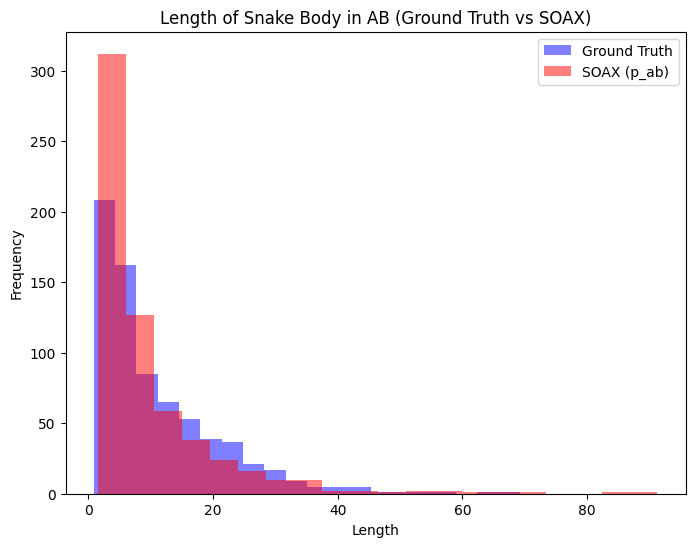

In [80]:
#plot the histogram of the length of the snake body for df_ab_gt and df_ab_p_ab_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_gt['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_ab_p_ab_combined['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax.set_title('Length of Snake Body in AB (Ground Truth vs SOAX)')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [81]:
mann_whitney_u_test(df_ab_gt['Length']*0.267, df_ab_p_ab_combined['Snake Body Length']*0.267,  name_data1='AB (gt)', name_data2='AB (p_ab)')

Doing Mann Whitney U Test for AB (gt) and AB (p_ab)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 0.0001788795694058926                    |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.5596039966161374                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.5284271626461924, 0.5907808305860823] |
+---------------------------------------------------+------------------------------------------+
| S

### Histogram of Intensity (AB ground truth vs AB p_ab)

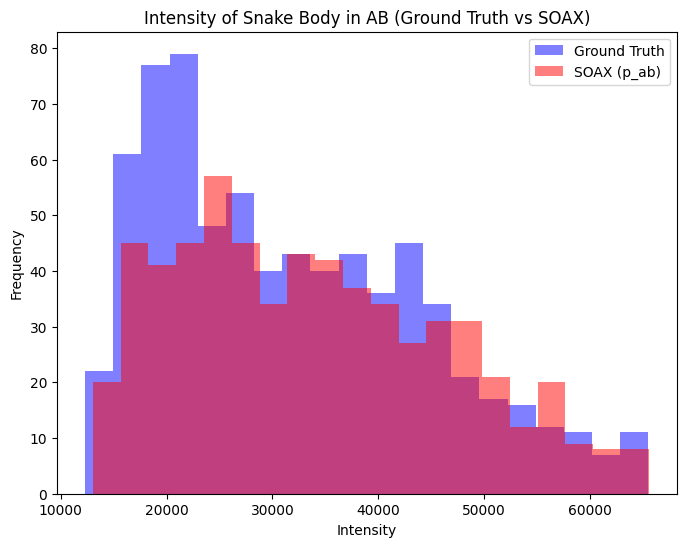

In [82]:
#plot the histogram of the intensity of the snake body for df_ab_gt and df_ab_p_ab_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_gt['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_ab_p_ab_combined['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax.set_title('Intensity of Snake Body in AB (Ground Truth vs SOAX)')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()



In [83]:
mann_whitney_u_test(df_ab_gt['Mean'], df_ab_p_ab_combined['Average FG Intensity'],  name_data1='AB (gt)', name_data2='AB (p_ab)')

Doing Mann Whitney U Test for AB (gt) and AB (p_ab)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+--------------------------------------------+
| Metric                                            | Value                                      |
+===================================================+============================================+
| p-value                                           | 0.0008397204528063516                      |
+---------------------------------------------------+--------------------------------------------+
| Effect size (rank biserial correlation)           | 0.4468802158355626                         |
+---------------------------------------------------+--------------------------------------------+
| Confidence interval for the difference in medians | [0.41570338186561756, 0.47805704980550756] |
+---------------------------------------------------+-------------------------------

### Histogram of Snake Lengths (AB ground truth vs AB p_bb)

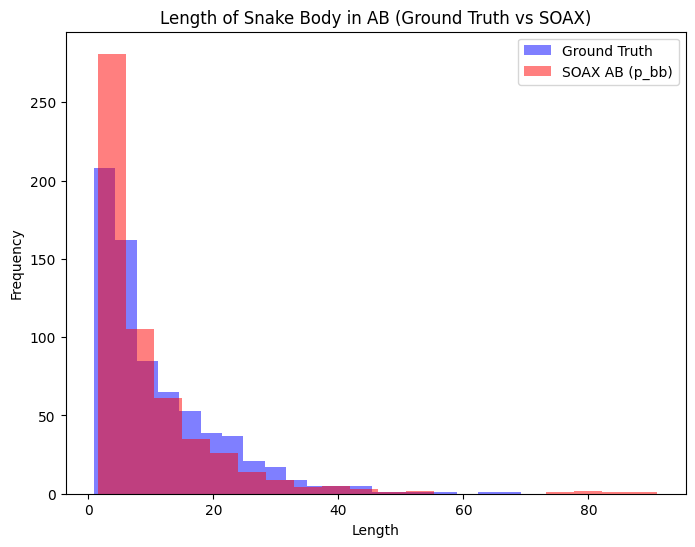

In [84]:
#plot the histogram of the length of the snake body for df_ab_gt and df_ab_p_bb_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_gt['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_ab_p_bb_combined['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX AB (p_bb)', color='red')
ax.set_title('Length of Snake Body in AB (Ground Truth vs SOAX)')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [85]:
mann_whitney_u_test(df_ab_gt['Length']*0.267, df_ab_p_bb_combined['Snake Body Length']*0.267,  name_data1='AB (gt)', name_data2='AB (p_bb)')

Doing Mann Whitney U Test for AB (gt) and AB (p_bb)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 0.0009691306511392806                    |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.5539794515866929                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.5219128525195524, 0.5860460506538333] |
+---------------------------------------------------+------------------------------------------+
| S

### Histogram of Intensity (AB ground truth vs AB p_ab)

### Histogram of Intensity (AB ground truth vs AB p_bb)

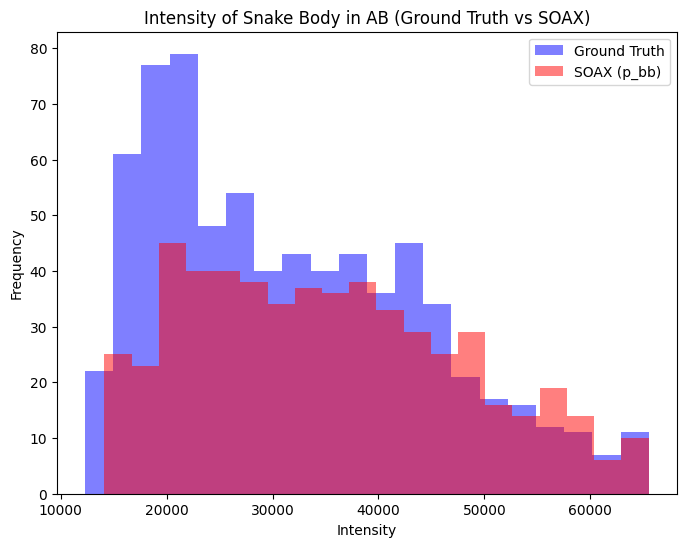

In [86]:
#plot the histogram of the intensity of the snake body for df_ab_gt and df_ab_p_bb_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_gt['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_ab_p_bb_combined['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX (p_bb)', color='red')
ax.set_title('Intensity of Snake Body in AB (Ground Truth vs SOAX)')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [87]:
mann_whitney_u_test(df_ab_gt['Mean'], df_ab_p_bb_combined['Average FG Intensity'],  name_data1='AB (gt)', name_data2='AB (p_bb)')

Doing Mann Whitney U Test for AB (gt) and AB (p_bb)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+--------------------------------------------+
| Metric                                            | Value                                      |
+===================================================+============================================+
| p-value                                           | 2.1260655492766727e-07                     |
+---------------------------------------------------+--------------------------------------------+
| Effect size (rank biserial correlation)           | 0.41511946074969563                        |
+---------------------------------------------------+--------------------------------------------+
| Confidence interval for the difference in medians | [0.38305286168255515, 0.44718605981683607] |
+---------------------------------------------------+-------------------------------

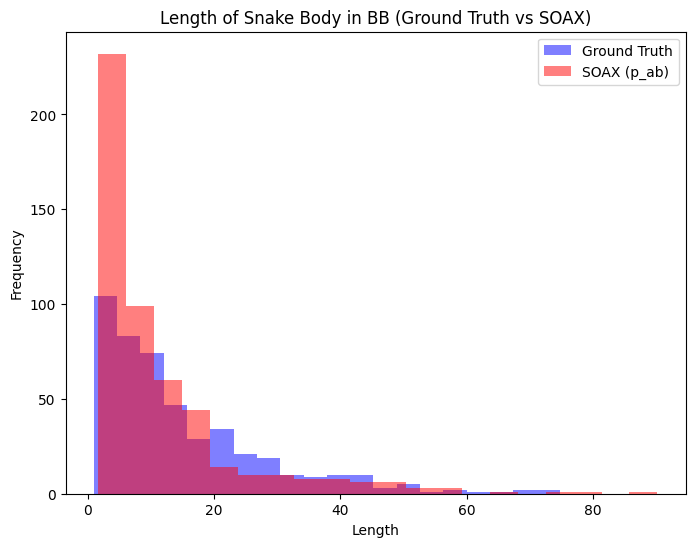

In [88]:
#plot the histogram of the length of the snake body for df_bb_gt and df_bb_p_bb_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_bb_gt['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_bb_p_ab_combined['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax.set_title('Length of Snake Body in BB (Ground Truth vs SOAX)')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

### Histogram of Snake Lengths (BB ground truth vs BB p_ab)

In [89]:
mann_whitney_u_test(df_bb_gt['Length']*0.267, df_bb_p_ab_combined['Snake Body Length']*0.267,  name_data1='BB (gt)', name_data2='BB (p_ab)')

Doing Mann Whitney U Test for BB (gt) and BB (p_ab)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 1.2252848985644814e-07                   |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.5979879122689203                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.5616803278431329, 0.6342954966947077] |
+---------------------------------------------------+------------------------------------------+
| S

### Histogram of Snake Lengths (BB ground truth vs BB p_bb)

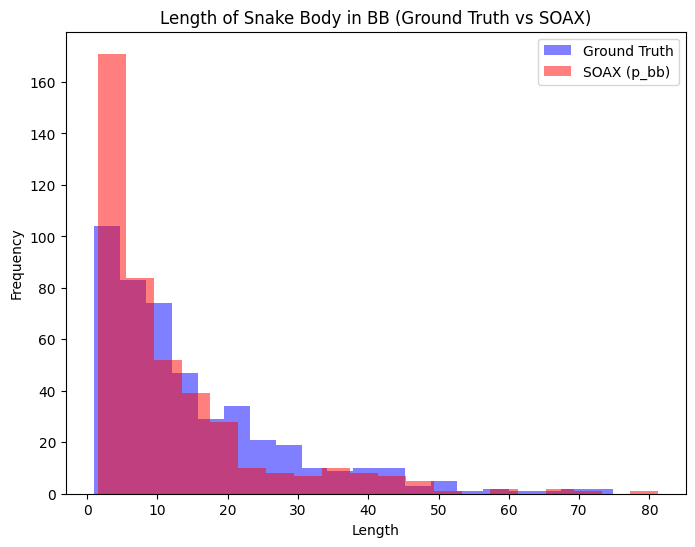

In [90]:
#plot the histogram of the length of the snake body for df_bb_gt and df_bb_p_bb_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_bb_gt['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_bb_p_bb_combined['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX (p_bb)', color='red')
ax.set_title('Length of Snake Body in BB (Ground Truth vs SOAX)')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [91]:
mann_whitney_u_test(df_bb_gt['Length']*0.267, df_bb_p_bb_combined['Snake Body Length']*0.267,  name_data1='BB (gt)', name_data2='BB (p_bb)')

Doing Mann Whitney U Test for BB (gt) and BB (p_bb)
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 4.51924720622923e-05                     |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.5784629589611614                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.5407630763150382, 0.6161628416072846] |
+---------------------------------------------------+------------------------------------------+
| S

### Histogram of Intensity (BB ground truth vs BB p_bb)

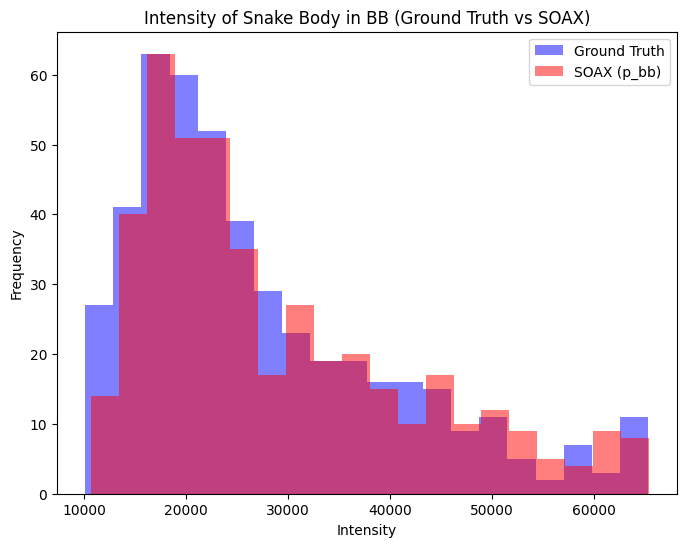

In [92]:
#plot the histogram of the intensity of the snake body for df_bb_gt and df_bb_p_bb_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_bb_gt['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_bb_p_bb_combined['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX (p_bb)', color='red')
ax.set_title('Intensity of Snake Body in BB (Ground Truth vs SOAX)')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [93]:
mann_whitney_u_test(df_bb_gt['Mean'], df_bb_p_bb_combined['Average FG Intensity'],  name_data1='BB (gt)', name_data2='BB (p_bb)')

Doing Mann Whitney U Test for BB (gt) and BB (p_bb)
The two datasets are not significantly different (fail to reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 0.06523817633009889                      |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.464535489067442                        |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.4268356064213188, 0.5022353717135652] |
+---------------------------------------------------+-----------------------------------

### Histogram of Length (BB ground truth vs BB p_ab)

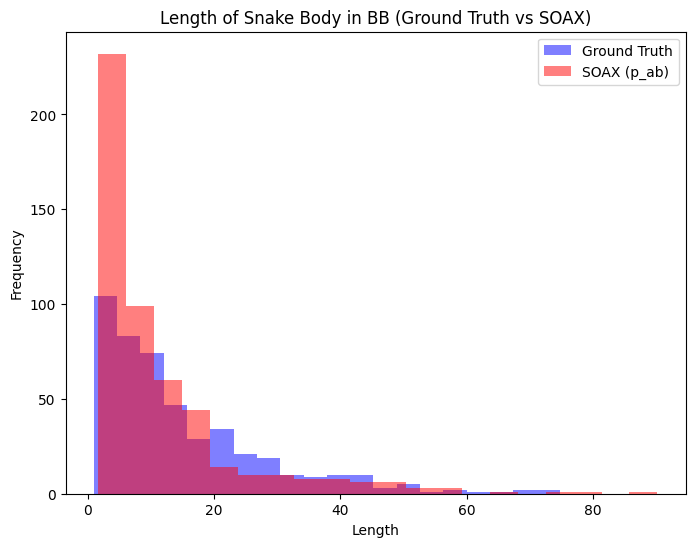

In [94]:
#plot the histogram of the length of the snake body for df_bb_gt and df_bb_p_ab_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_bb_gt['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_bb_p_ab_combined['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax.set_title('Length of Snake Body in BB (Ground Truth vs SOAX)')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

### Histogram of Intensity (BB ground truth vs BB p_ab)

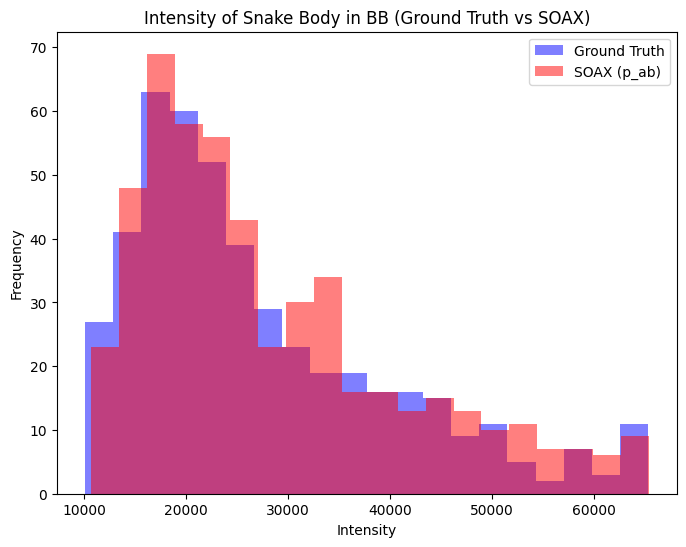

In [95]:
#plot the histogram of the intensity of the snake body for df_bb_gt and df_bb_p_ab_combined
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_bb_gt['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(df_bb_p_ab_combined['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax.set_title('Intensity of Snake Body in BB (Ground Truth vs SOAX)')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [96]:
mann_whitney_u_test(df_bb_gt["Mean"], df_bb_p_ab_combined["Average FG Intensity"], name_data1='BB (gt)', name_data2='BB (p_ab)')

Doing Mann Whitney U Test for BB (gt) and BB (p_ab)
The two datasets are not significantly different (fail to reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 0.17282455955138298                      |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.4747454269773492                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.4384378425515618, 0.5110530114031366] |
+---------------------------------------------------+-----------------------------------

### Histogram of Length (AB ground truth vs BB ground truth)

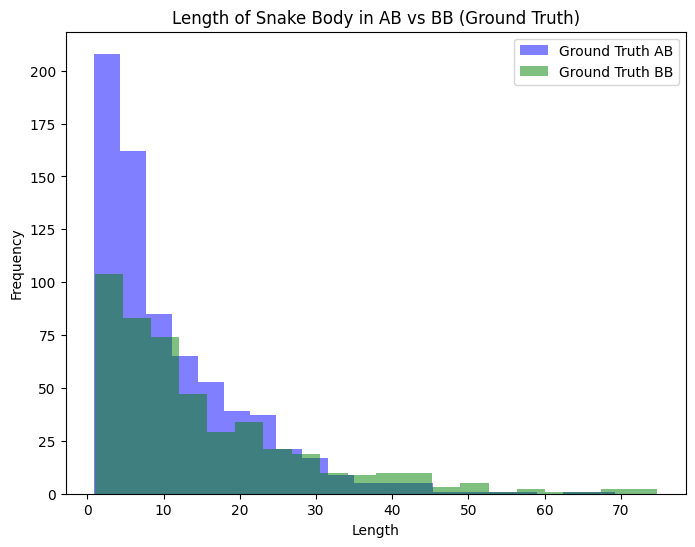

In [97]:
#plot the histogram of the length of the snake body for df_ab_gt and df_ab_gt
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_gt['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth AB', color='blue')
ax.hist(df_bb_gt['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth BB', color='green')
ax.set_title('Length of Snake Body in AB vs BB (Ground Truth)')
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [98]:
mann_whitney_u_test(df_ab_gt['Length']*0.267, df_bb_gt['Length']*0.267,  name_data1='AB (GT) Length', name_data2='BB (GT) Length')

Doing Mann Whitney U Test for AB (GT) Length and BB (GT) Length
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+--------------------------------------------+
| Metric                                            | Value                                      |
+===================================================+============================================+
| p-value                                           | 2.1466876307803316e-06                     |
+---------------------------------------------------+--------------------------------------------+
| Effect size (rank biserial correlation)           | 0.4186131245165587                         |
+---------------------------------------------------+--------------------------------------------+
| Confidence interval for the difference in medians | [0.38495432478333325, 0.45227192424978413] |
+---------------------------------------------------+-------------------

### Histogram of Intensity (AB ground truth vs BB ground truth)

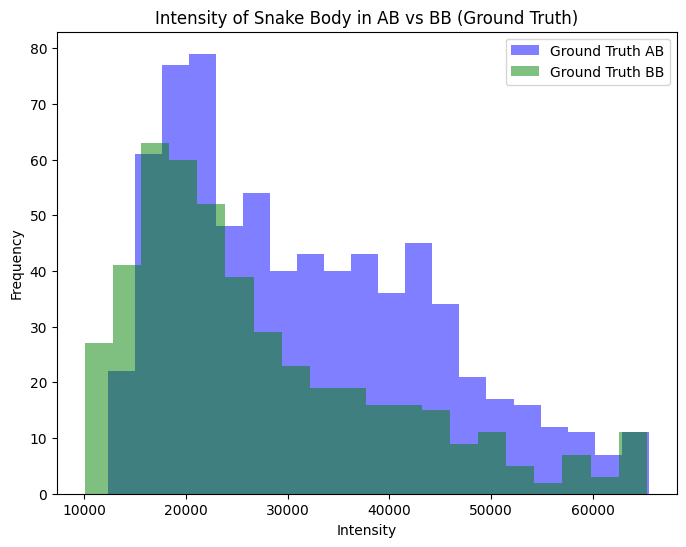

In [99]:
#plot the histogram of the intensity of the snake body for df_ab_gt and df_bb_gt
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ab_gt['Mean'], bins=20, alpha=0.5, label='Ground Truth AB', color='blue')
ax.hist(df_bb_gt['Mean'], bins=20, alpha=0.5, label='Ground Truth BB', color='green')
ax.set_title('Intensity of Snake Body in AB vs BB (Ground Truth)')
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [100]:
mann_whitney_u_test(df_ab_gt['Mean'], 
                    df_bb_gt['Mean'],  
                    name_data1='AB (GT) Intensity', 
                    name_data2='BB (GT) Intensity')

Doing Mann Whitney U Test for AB (GT) Intensity and BB (GT) Intensity
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-----------------------------------------+
| Metric                                            | Value                                   |
+===================================================+=========================================+
| p-value                                           | 5.291285892026754e-11                   |
+---------------------------------------------------+-----------------------------------------+
| Effect size (rank biserial correlation)           | 0.6127004321479875                      |
+---------------------------------------------------+-----------------------------------------+
| Confidence interval for the difference in medians | [0.5790416324147621, 0.646359231881213] |
+---------------------------------------------------+-------------------------------------

# Analysis for Filtering Snakes that are less than 10*0.267 um 

In [101]:
#do anlaysis for filtering snakes that are less than 10 pixels in length
df_ab_p_ab_combined_filtered = df_ab_p_ab_combined[df_ab_p_ab_combined['Snake Body Length']>10]
df_bb_p_ab_combined_filtered = df_bb_p_ab_combined[df_bb_p_ab_combined['Snake Body Length']>10]

df_ab_p_bb_combined_filtered = df_ab_p_bb_combined[df_ab_p_bb_combined['Snake Body Length']>10]
df_bb_p_bb_combined_filtered = df_bb_p_bb_combined[df_bb_p_bb_combined['Snake Body Length']>10]

df_ab_gt_filtered = df_ab_gt[df_ab_gt['Length']>10]
df_bb_gt_filtered = df_bb_gt[df_bb_gt['Length']>10]

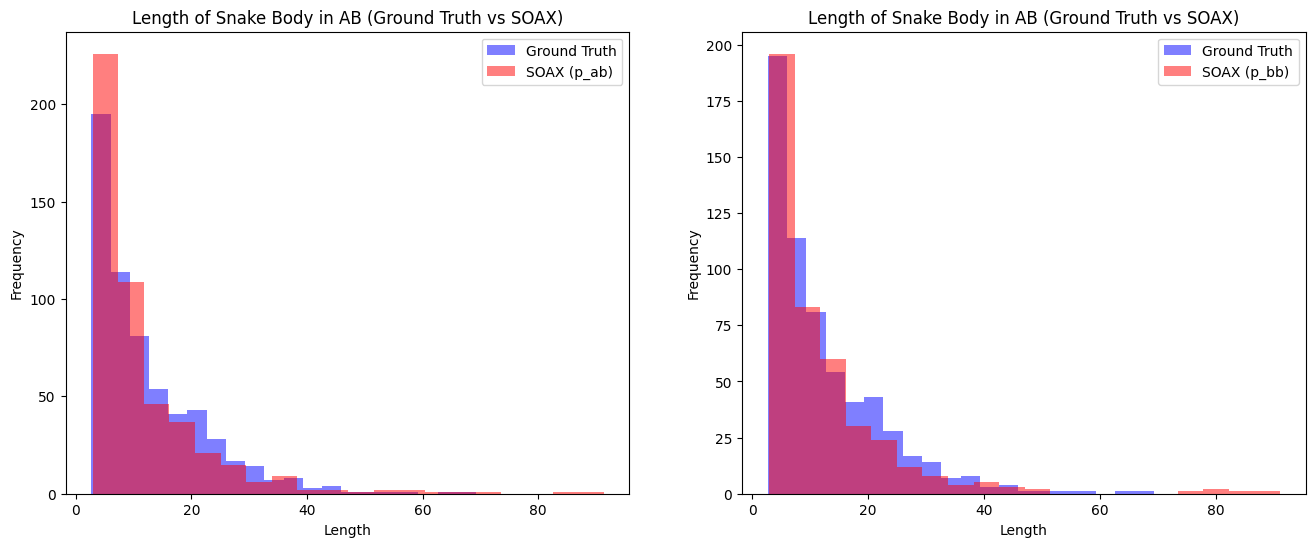

In [102]:
#plot the histogram of the length of the snake body on different axes for  
#1) df_ab_gt_filtered and df_ab_p_ab_combined_filtered 
#2) df_ab_gt_filtered and df_ab_p_bb_combined_filtered 

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(df_ab_gt_filtered['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax[0].hist(df_ab_p_ab_combined_filtered['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax[0].set_title('Length of Snake Body in AB (Ground Truth vs SOAX)')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].hist(df_ab_gt_filtered['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax[1].hist(df_ab_p_bb_combined_filtered['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX (p_bb)', color='red')
ax[1].set_title('Length of Snake Body in AB (Ground Truth vs SOAX)')
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.show()


In [103]:
#do statistical test for length of snake body for filtered data for ground truth and SOAX for AB and BB
mann_whitney_u_test(df_ab_gt_filtered['Length']*0.267, df_ab_p_ab_combined_filtered['Snake Body Length']*0.267,  name_data1='AB (GT) Length', name_data2='AB (p_ab) Length')


Doing Mann Whitney U Test for AB (GT) Length and AB (p_ab) Length
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 0.01295455945898577                      |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.5436348028076554                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.5092200074885727, 0.5780495981267382] |
+---------------------------------------------------+---------------------------------

In [104]:
mann_whitney_u_test(df_ab_gt_filtered['Length']*0.267, df_ab_p_bb_combined_filtered['Snake Body Length']*0.267,  name_data1='AB (GT) Length', name_data2='AB (p_bb) Length')

Doing Mann Whitney U Test for AB (GT) Length and AB (p_bb) Length
The two datasets are not significantly different (fail to reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 0.08033202133760105                      |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.5317073170731708                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.4961721241153442, 0.5672425100309972] |
+---------------------------------------------------+---------------------

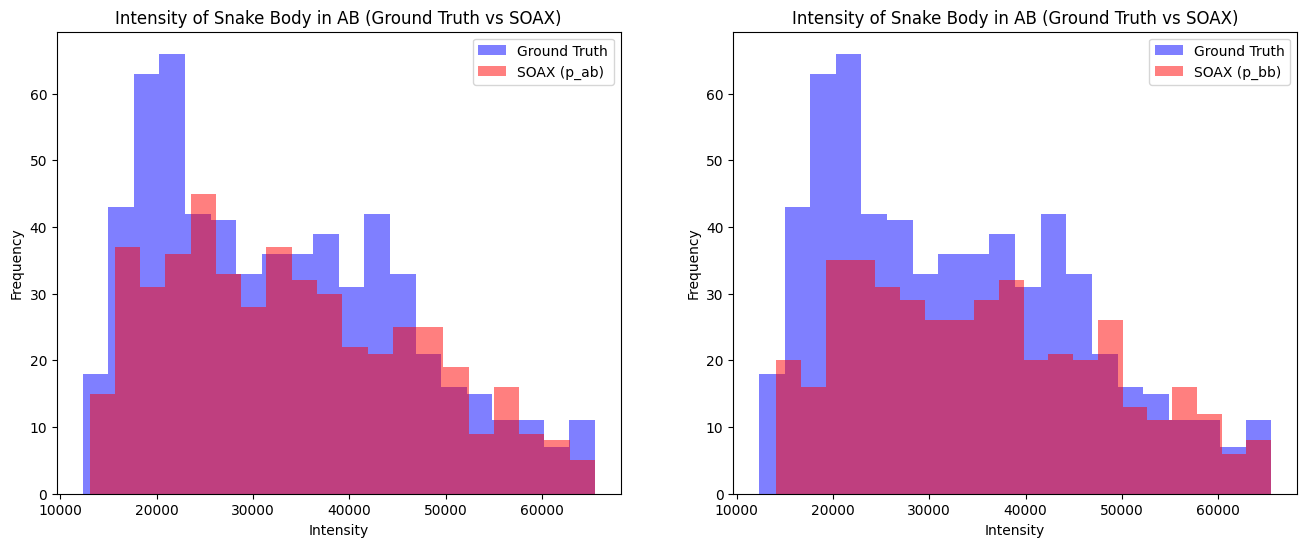

In [105]:
#plot the histogram of the intensity of the snake body on different axes for  
#1) df_ab_gt_filtered and df_ab_p_ab_combined_filtered 
#2) df_ab_gt_filtered and df_ab_p_bb_combined_filtered 

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(df_ab_gt_filtered['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax[0].hist(df_ab_p_ab_combined_filtered['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax[0].set_title('Intensity of Snake Body in AB (Ground Truth vs SOAX)')
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].hist(df_ab_gt_filtered['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax[1].hist(df_ab_p_bb_combined_filtered['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX (p_bb)', color='red')
ax[1].set_title('Intensity of Snake Body in AB (Ground Truth vs SOAX)')
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.show()

In [106]:
#do mann whitney u test for intensity of snake body for filtered data for ground truth and SOAX for AB 
mann_whitney_u_test(df_ab_gt_filtered['Mean'], df_ab_p_ab_combined_filtered['Average FG Intensity'],  name_data1='AB (GT) Intensity', name_data2='AB (p_ab) Intensity')

Doing Mann Whitney U Test for AB (GT) Intensity and AB (p_ab) Intensity
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+--------------------------------------------+
| Metric                                            | Value                                      |
+===================================================+============================================+
| p-value                                           | 0.04983755004730464                        |
+---------------------------------------------------+--------------------------------------------+
| Effect size (rank biserial correlation)           | 0.46555909037351245                        |
+---------------------------------------------------+--------------------------------------------+
| Confidence interval for the difference in medians | [0.43114429505442964, 0.49997388569259515] |
+---------------------------------------------------+-----------

In [107]:
mann_whitney_u_test(df_ab_gt_filtered['Mean'], df_ab_p_bb_combined_filtered['Average FG Intensity'],  name_data1='AB (GT) Intensity', name_data2='AB (p_bb) Intensity')

Doing Mann Whitney U Test for AB (GT) Intensity and AB (p_bb) Intensity
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-------------------------------------------+
| Metric                                            | Value                                     |
+===================================================+===========================================+
| p-value                                           | 0.00029383533039285115                    |
+---------------------------------------------------+-------------------------------------------+
| Effect size (rank biserial correlation)           | 0.4343533574224631                        |
+---------------------------------------------------+-------------------------------------------+
| Confidence interval for the difference in medians | [0.39881816446463664, 0.4698885503802896] |
+---------------------------------------------------+-------------------

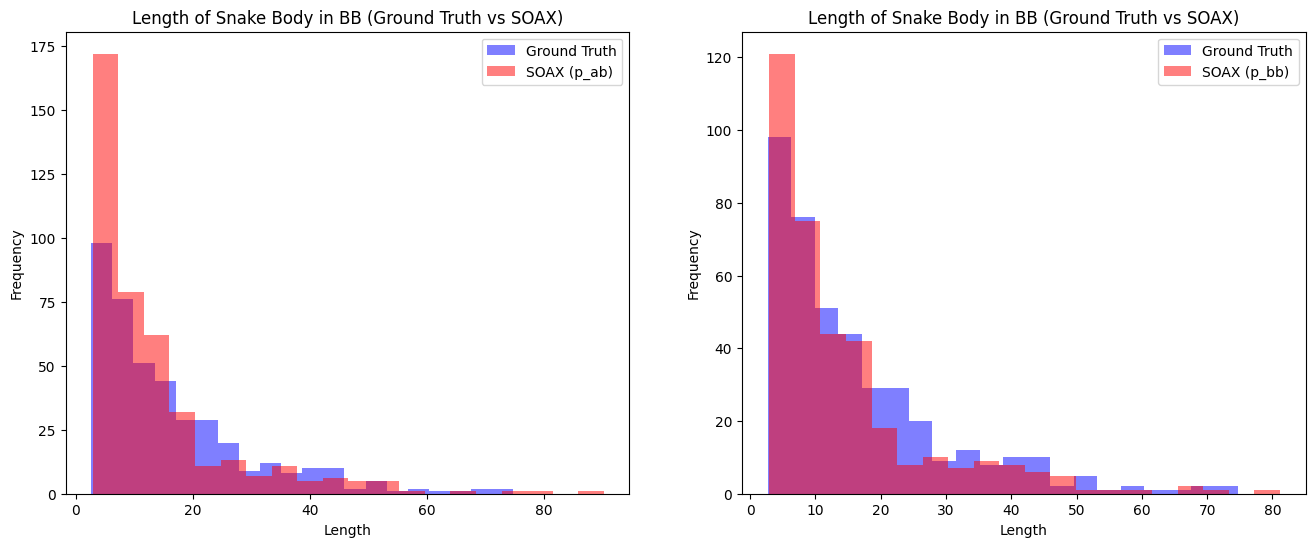

In [108]:
#plot the histogram of the length of the snake body on different axes for  
#1) df_bb_gt_filtered and df_bb_p_ab_combined_filtered 
#2) df_bb_gt_filtered and df_bb_p_bb_combined_filtered 

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(df_bb_gt_filtered['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax[0].hist(df_bb_p_ab_combined_filtered['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax[0].set_title('Length of Snake Body in BB (Ground Truth vs SOAX)')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].hist(df_bb_gt_filtered['Length']*0.267, bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax[1].hist(df_bb_p_bb_combined_filtered['Snake Body Length']*0.267, bins=20, alpha=0.5, label='SOAX (p_bb)', color='red')
ax[1].set_title('Length of Snake Body in BB (Ground Truth vs SOAX)')
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.show()

In [109]:
mann_whitney_u_test(df_bb_gt_filtered['Length']*0.267, df_bb_p_ab_combined_filtered['Snake Body Length']*0.267,  name_data1='BB (GT) Length', name_data2='BB (p_ab) Length')

Doing Mann Whitney U Test for BB (GT) Length and BB (p_ab) Length
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-----------------------------------------+
| Metric                                            | Value                                   |
+===================================================+=========================================+
| p-value                                           | 3.208177266146994e-06                   |
+---------------------------------------------------+-----------------------------------------+
| Effect size (rank biserial correlation)           | 0.5936669879404781                      |
+---------------------------------------------------+-----------------------------------------+
| Confidence interval for the difference in medians | [0.554246330968864, 0.6330876449120924] |
+---------------------------------------------------+-----------------------------------------

In [110]:
mann_whitney_u_test(df_bb_gt_filtered['Length']*0.267, df_bb_p_bb_combined_filtered['Snake Body Length']*0.267, name_data1='BB (GT) Length', name_data2='BB (p_bb) Length')

Doing Mann Whitney U Test for BB (GT) Length and BB (p_bb) Length
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 0.0004983800571638116                    |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.572559331175836                        |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.5317135358739912, 0.6134051264776809] |
+---------------------------------------------------+---------------------------------

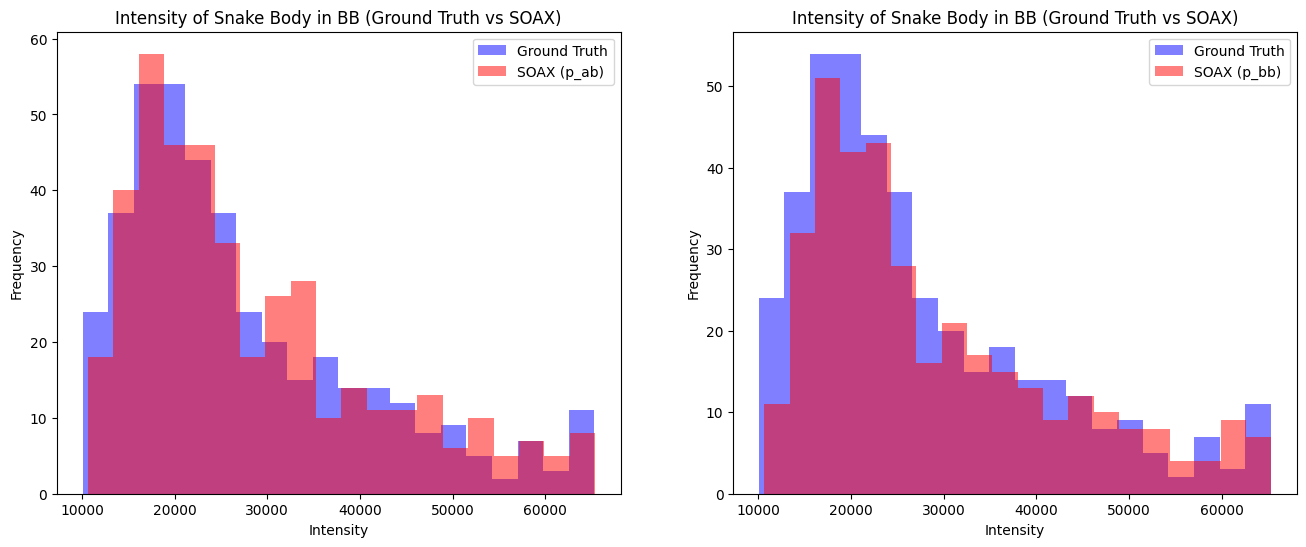

In [111]:
#plot the histogram of the intensity of the snake body on different axes for  
#1) df_bb_gt_filtered and df_bb_p_ab_combined_filtered 
#2) df_bb_gt_filtered and df_bb_p_bb_combined_filtered 

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(df_bb_gt_filtered['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax[0].hist(df_bb_p_ab_combined_filtered['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX (p_ab)', color='red')
ax[0].set_title('Intensity of Snake Body in BB (Ground Truth vs SOAX)')
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].hist(df_bb_gt_filtered['Mean'], bins=20, alpha=0.5, label='Ground Truth', color='blue')
ax[1].hist(df_bb_p_bb_combined_filtered['Average FG Intensity'], bins=20, alpha=0.5, label='SOAX (p_bb)', color='red')
ax[1].set_title('Intensity of Snake Body in BB (Ground Truth vs SOAX)')
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.show()

In [112]:
mann_whitney_u_test(df_bb_gt_filtered['Mean'], df_bb_p_ab_combined_filtered['Average FG Intensity'],  name_data1='BB (GT) Intensity', name_data2='BB (p_ab) Intensity')

Doing Mann Whitney U Test for BB (GT) Intensity and BB (p_ab) Intensity
The two datasets are not significantly different (fail to reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 0.23891491190906566                      |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.47630997437645456                      |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.4368893174048404, 0.5157306313480687] |
+---------------------------------------------------+---------------

In [113]:
mann_whitney_u_test(df_bb_gt_filtered['Mean'], df_bb_p_bb_combined_filtered['Average FG Intensity'], name_data1='BB (GT) Intensity', name_data2='BB (p_bb) Intensity')

Doing Mann Whitney U Test for BB (GT) Intensity and BB (p_bb) Intensity
The two datasets are not significantly different (fail to reject H0)

Test Results:
+---------------------------------------------------+-------------------------------------------+
| Metric                                            | Value                                     |
+===================================================+===========================================+
| p-value                                           | 0.06619397698166535                       |
+---------------------------------------------------+-------------------------------------------+
| Effect size (rank biserial correlation)           | 0.4617111650485437                        |
+---------------------------------------------------+-------------------------------------------+
| Confidence interval for the difference in medians | [0.42086536974669886, 0.5025569603503885] |
+---------------------------------------------------+-------

(array([61., 38., 32., 35., 35., 31., 33., 17., 23., 26.]),
 array([2.673738, 3.384492, 4.095246, 4.806   , 5.516754, 6.227508,
        6.938262, 7.649016, 8.35977 , 9.070524, 9.781278]),
 <BarContainer object of 10 artists>)

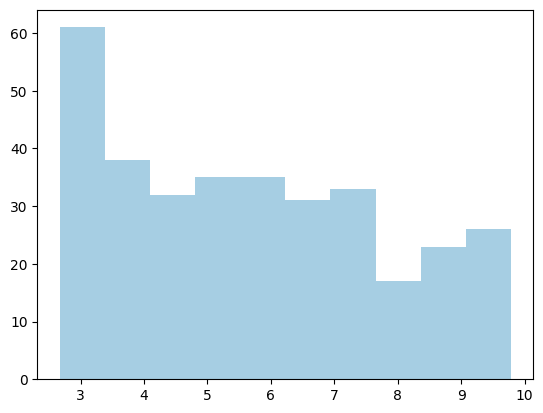

In [157]:
plt.hist(df_ab_gt_filtered['Length'][df_ab_gt_filtered['Length']*0.267<10]*0.267)

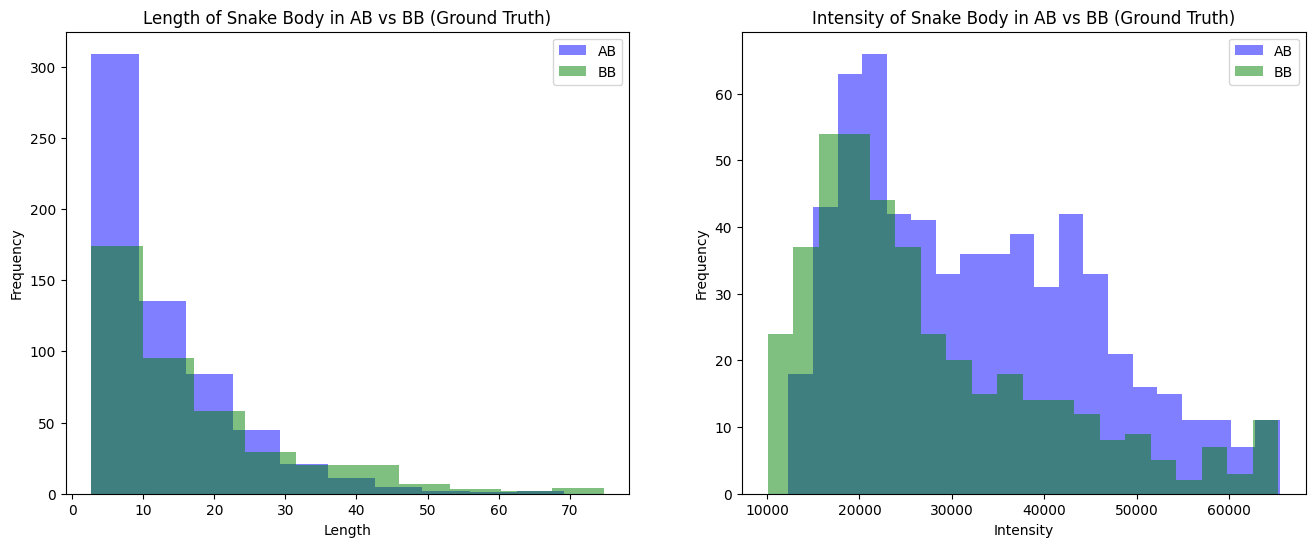

In [160]:
#do histogram for length and intensity for ground truth data 

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(df_ab_gt_filtered['Length']*0.267, bins=10, alpha=0.5, label='AB', color='blue')
ax[0].hist(df_bb_gt_filtered['Length']*0.267, bins=10, alpha=0.5, label='BB', color='green')
ax[0].set_title('Length of Snake Body in AB vs BB (Ground Truth)')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].hist(df_ab_gt_filtered['Mean'], bins=20, alpha=0.5, label='AB', color='blue')
ax[1].hist(df_bb_gt_filtered['Mean'], bins=20, alpha=0.5, label='BB', color='green')
ax[1].set_title('Intensity of Snake Body in AB vs BB (Ground Truth)')
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.show()

In [115]:
mann_whitney_u_test(df_ab_gt_filtered['Length']*0.267, df_bb_gt_filtered['Length']*0.267,  name_data1='AB (GT) Length', name_data2='BB (GT) Length')

Doing Mann Whitney U Test for AB (GT) Length and BB (GT) Length
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-------------------------------------------+
| Metric                                            | Value                                     |
+===================================================+===========================================+
| p-value                                           | 4.955744103582608e-07                     |
+---------------------------------------------------+-------------------------------------------+
| Effect size (rank biserial correlation)           | 0.4075459783724051                        |
+---------------------------------------------------+-------------------------------------------+
| Confidence interval for the difference in medians | [0.3715073826935068, 0.44358457405130336] |
+---------------------------------------------------+---------------------------

In [116]:
mann_whitney_u_test(df_ab_gt_filtered['Mean'], df_bb_gt_filtered['Mean'],  name_data1='AB (GT) Intensity', name_data2='BB (GT) Intensity')

Doing Mann Whitney U Test for AB (GT) Intensity and BB (GT) Intensity
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+------------------------------------------+
| Metric                                            | Value                                    |
+===================================================+==========================================+
| p-value                                           | 1.8982893971299366e-12                   |
+---------------------------------------------------+------------------------------------------+
| Effect size (rank biserial correlation)           | 0.6294814113189675                       |
+---------------------------------------------------+------------------------------------------+
| Confidence interval for the difference in medians | [0.5934428156400694, 0.6655200069978657] |
+---------------------------------------------------+-----------------------------

In [122]:
df_ab_gt.columns = ['SnakeNum', 'Area', 'Mean', 'StdDev', 'Mode', 'Median', 'Skew', 'Kurt',
       'Length']

df_bb_gt.columns = ['SnakeNum', 'Area', 'Mean', 'StdDev', 'Mode', 'Median', 'Skew', 'Kurt','Length']

In [125]:
df_ab_gt_filtered.columns = ['SnakeNum', 'Area', 'Mean', 'StdDev', 'Mode', 'Median', 'Skew', 'Kurt',
       'Length']

df_bb_gt_filtered.columns = ['SnakeNum', 'Area', 'Mean', 'StdDev', 'Mode', 'Median', 'Skew', 'Kurt','Length']

In [135]:
#loop through df_ab_gt_filtered['SnakeNum'] and find out the number of snakes in each sample
#each new sample is starting from 1 in the 'SnakeNum' column

count_ab_gt_filtered = []
temp_arr = []
for i in df_ab_gt_filtered['SnakeNum'].values:
    if temp_arr == []:
        temp_arr.append(i)
    elif temp_arr[-1]<i:
        temp_arr.append(i)
    elif temp_arr[-1]>i:
        count_ab_gt_filtered.append(len(temp_arr))
        temp_arr = []
        temp_arr.append(i)

In [139]:
def process_data(data, temp_arr, count_arr):
    for i in data:
        if not temp_arr:
            temp_arr.append(i)
        elif temp_arr[-1] < i:
            temp_arr.append(i)
        elif temp_arr[-1] > i:
            count_arr.append(len(temp_arr))
            temp_arr.clear()
            temp_arr.append(i)
    return count_arr

In [144]:
tp_arr = []
ct_arr = []
assert count_ab_gt_filtered == process_data(df_ab_gt_filtered['SnakeNum'].values, [], [])

In [146]:
count_ab_gt_filtered = []
count_bb_gt_filtered = []
count_ab_gt_filtered = process_data(df_ab_gt_filtered['SnakeNum'].values, [], count_ab_gt_filtered)
count_bb_gt_filtered = process_data(df_bb_gt_filtered['SnakeNum'].values, [], count_bb_gt_filtered)

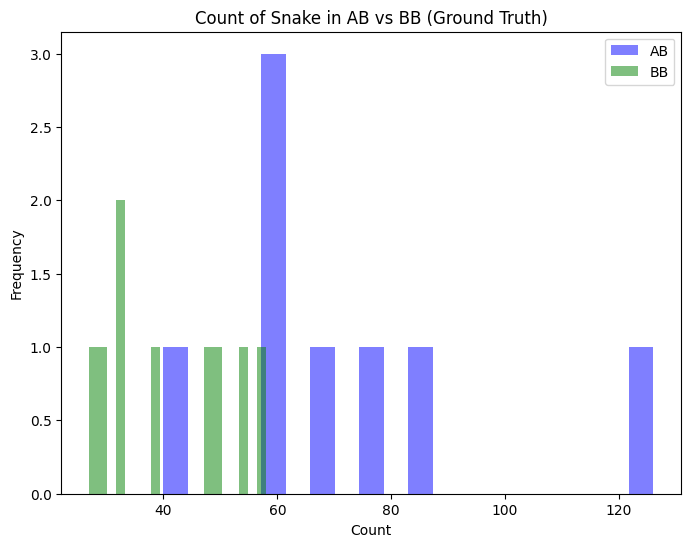

In [147]:
#plot the histogram of the count of the snake for df_ab_gt_filtered and df_bb_gt_filtered
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(count_ab_gt_filtered, bins=20, alpha=0.5, label='AB', color='blue')
ax.hist(count_bb_gt_filtered, bins=20, alpha=0.5, label='BB', color='green')
ax.set_title('Count of Snake in AB vs BB (Ground Truth)')
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [148]:
#do statistical test for count of snakes for ground truth data
mann_whitney_u_test(count_ab_gt_filtered, count_bb_gt_filtered,  name_data1='AB (GT) Count', name_data2='BB (GT) Count')


Doing Mann Whitney U Test for AB (GT) Count and BB (GT) Count
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-----------------------------------------+
| Metric                                            | Value                                   |
+===================================================+=========================================+
| p-value                                           | 0.002820628254955192                    |
+---------------------------------------------------+-----------------------------------------+
| Effect size (rank biserial correlation)           | 0.9375                                  |
+---------------------------------------------------+-----------------------------------------+
| Confidence interval for the difference in medians | [0.6546035664809571, 1.220396433519043] |
+---------------------------------------------------+-----------------------------------------+
| 

In [150]:
from tabulate import tabulate

table = [
    ["p-value", "{:.6f}".format(0.002820628254955192)],
    ["Effect size (rank biserial correlation)", "{:.6f}".format(0.9375)],
    ["Confidence interval for the difference in medians", "[{:.6f}, {:.6f}]".format(0.6546035664809571, 1.220396433519043)],
    ["Statistical power", "{:.6f}".format(0.8477131781851166)]
]

print(tabulate(table, headers=['Metric', 'Value']))

Metric                                             Value
-------------------------------------------------  --------------------
p-value                                            0.002821
Effect size (rank biserial correlation)            0.937500
Confidence interval for the difference in medians  [0.654604, 1.220396]
Statistical power                                  0.847713


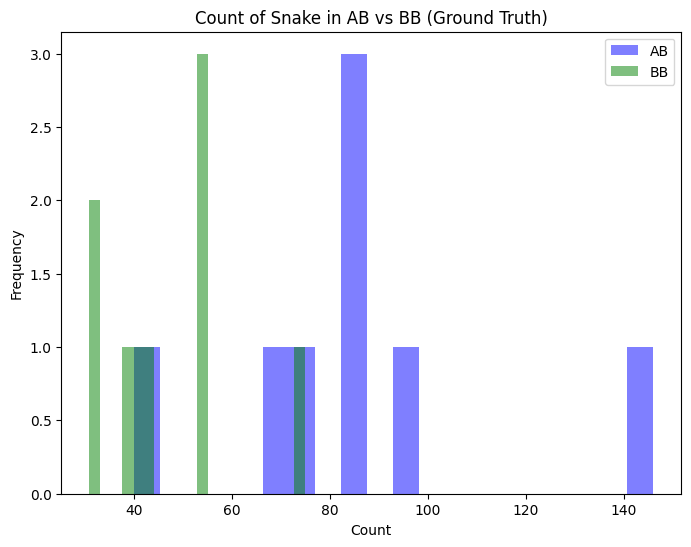

Doing Mann Whitney U Test for AB (GT) Count and BB (GT) Count
The two datasets are significantly different (reject H0)

Test Results:
+---------------------------------------------------+-----------------------------------------+
| Metric                                            | Value                                   |
+===================================================+=========================================+
| p-value                                           | 0.005179223349788703                    |
+---------------------------------------------------+-----------------------------------------+
| Effect size (rank biserial correlation)           | 0.9097222222222222                      |
+---------------------------------------------------+-----------------------------------------+
| Confidence interval for the difference in medians | [0.6268257887031793, 1.192618655741265] |
+---------------------------------------------------+-----------------------------------------+
| 

In [152]:
#do this count plot for regular data df_ab_gt and df_bb_gt and do the statistical test for the count of snakes
count_ab_gt = []
count_bb_gt = []

count_ab_gt = process_data(df_ab_gt['SnakeNum'].values, [], count_ab_gt)
count_bb_gt = process_data(df_bb_gt['SnakeNum'].values, [], count_bb_gt)

#plot the histogram of the count of the snake for df_ab_gt and df_bb_gt
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(count_ab_gt, bins=20, alpha=0.5, label='AB', color='blue')
ax.hist(count_bb_gt, bins=20, alpha=0.5, label='BB', color='green')
ax.set_title('Count of Snake in AB vs BB (Ground Truth)')
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

#do statistical test for count of snakes for ground truth data
mann_whitney_u_test(count_ab_gt, count_bb_gt,  name_data1='AB (GT) Count', name_data2='BB (GT) Count')

In [153]:
from tabulate import tabulate

table = [
    ["p-value", "{:.6f}".format(0.005179223349788703)],
    ["Effect size (rank biserial correlation)", "{:.6f}".format(0.9097222222222222)],
    ["Confidence interval for the difference in medians", "[{:.6f}, {:.6f}]".format(0.6268257887031793, 1.192618655741265)],
    ["Statistical power", "{:.6f}".format(0.7983398821843093)]
]

print(tabulate(table, headers=['Metric', 'Value']))

Metric                                             Value
-------------------------------------------------  --------------------
p-value                                            0.005179
Effect size (rank biserial correlation)            0.909722
Confidence interval for the difference in medians  [0.626826, 1.192619]
Statistical power                                  0.798340
